In [1]:
from util.datagen import generator
from util.model import *
from cfg import *

import segmentation_models as sm
sm.set_framework('tf.keras')
import tensorflow.keras.backend as k
import gc

from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import os, glob, datetime
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
    # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
        print(e)
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['figure.figsize'] = (10,8)

Segmentation Models: using `keras` framework.


---

## CROSS VALIDATION

In [6]:
# Iterator로부터 create dataset
test_set = tf.data.Dataset.from_generator(
    file_gen,
    tf.string, 
    output_shapes = tf.TensorShape([None]),
    args = (TEST_ZIP,)
)
# dataset을 img load func에 mapping
test_set = test_set.map(lambda input_paths : tf.numpy_function(
    test_map_func,
    [input_paths],
    [tf.float32,tf.float32]
),num_parallel_calls=tf.data.experimental.AUTOTUNE)
# batch size
test_set = test_set.batch(BATCH_SIZE,drop_remainder=True)
# buffer
test_set = test_set.prefetch(buffer_size = tf.data.experimental.AUTOTUNE)

In [ ]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=4,shuffle=True,random_state=311)
TRAIN_VAL_SLIDES = TRAIN_SLIDE_PATHS + VALID_SLIDE_PATHS
n_fold = 0
for x in kfold.split(TRAIN_VAL_SLIDES):
    train_idxs = x[0]; val_idxs = x[1]
    train_slides = []; val_slides = []; TRAIN_ZIP = []; VALID_ZIP = []
    
    for i,j in enumerate(TRAIN_VAL_SLIDES):
        if i in train_idxs:
            train_slides.append(TRAIN_VAL_SLIDES[i])
        else:
            val_slides.append(TRAIN_VAL_SLIDES[i])
    
    for path in train_slides:
        slide_name = path.split('/')[-1].replace('.tiff','').replace('svs','')
        patient_path = '/'.join(path.split('/')[:-1]) + '/'
        for lbl in TRUE_LABEL_LIST :
            target_list = glob.glob(patient_path+f'{PATCH_NAME}/mask/{slide_name}*_p{lbl["label"]}.png')
            if lbl['restrict']==0:
                TRAIN_ZIP.extend(target_list)
            else:
                TRAIN_ZIP.extend(shuffle(target_list,random_state = 311)[:lbl["restrict"]])
        for lbl in ZERO_LABEL_LIST :
            target_list = glob.glob(patient_path+f'{PATCH_NAME}/mask/{slide_name}*_p{lbl["label"]}.png')
            TRAIN_ZIP.extend(shuffle(target_list,random_state = 311)[:lbl["restrict"]])
    TRAIN_ZIP = shuffle([('/'.join(x.split('/')[:-2])+'/image/'+re.sub('_p[0-9]','',x.split('/')[-1]),x) for x in TRAIN_ZIP],random_state=311)
    
    for path in val_slides:
        slide_name = path.split('/')[-1].replace('.tiff','').replace('svs','')
        patient_path = '/'.join(path.split('/')[:-1]) + '/'
        for lbl in TRUE_LABEL_LIST :
            target_list = glob.glob(patient_path+f'{PATCH_NAME}/mask/{slide_name}*_p{lbl["label"]}.png')
            if lbl['restrict']==0:
                VALID_ZIP.extend(target_list) 
            else:
                VALID_ZIP.extend(shuffle(target_list,random_state = 311)[:lbl["restrict"]])
        for lbl in ZERO_LABEL_LIST :
            target_list = glob.glob(patient_path+f'{PATCH_NAME}/mask/{slide_name}*_p{lbl["label"]}.png')
            VALID_ZIP.extend(shuffle(target_list,random_state = 311)[:lbl["restrict"]])
    VALID_ZIP = shuffle([('/'.join(x.split('/')[:-2])+'/image/'+re.sub('_p[0-9]','',x.split('/')[-1]),x) for x in VALID_ZIP],random_state=311)

    # Iterator로부터 create dataset
    train_gen = generator(
        TRAIN_ZIP,
        BATCH_SIZE,
        ZERO_LABELS,
        is_train=True,
        binary=binary
    )
    valid_gen = generator(
        VALID_ZIP,
        BATCH_SIZE,
        ZERO_LABELS,
        is_train=False,
        binary=binary
    )
    # ---------------- 
    
    # Train
    # ----------------
    MODEL = 'unet'
    TODAY = datetime.datetime.now().strftime('%m%d')
    BACKBONE = 'efficientnetb0'
    WEIGHT = 'imagenet'
    LOSS = 'focal_dice'
    N_CLASSES = 1

    MODEL_PATH = os.path.join('./model/',(CLASS_NAME+'_'+str(MAGNIFICATION)+'_'+MODEL+'_'+BACKBONE+'_'+WEIGHT+'_'+TODAY +str(n_fold) +'.hdf5'))
    print(MODEL_PATH)
    
    # Loss, Optim, Metric
    dice_loss = sm.losses.DiceLoss()
    focal_loss = sm.losses.BinaryFocalLoss(alpha=0.25, gamma=6.0)
    loss = dice_loss + focal_loss
    optim = Adam(INITIAL_LEARNING_RATE)
    metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]
    
    ## MULTIGPU
    import tensorflow as tf
    strategy = tf.distribute.MirroredStrategy()
    print('Number of devices: {}'.format(strategy.num_replicas_in_sync))
    with strategy.scope():
        model = build_seg_model(model = MODEL,backbone=BACKBONE,weight = WEIGHT,input_shape=INPUT_SHAPE,n_classes=N_CLASSES)
        #model = sm.Deeplabv3(weights = WEIGHT,input_shape=INPUT_SHAPE,classes = N_CLASSES,activation=ACTIVATION,backbone=BACKBONE)
        #model = sm.Unet(BACKBONE, input_shape = INPUT_SHAPE,classes=N_CLASSES, activation=ACTIVATION,encoder_weights=WEIGHT,encoder_freeze=True)
        model.compile(optim, loss, metrics)
        
    class LossAndErrorPrintingCallback(tf.keras.callbacks.Callback):
        def on_train_batch_end(self, batch, logs=None):
            print("For batch {}, tr_loss is {:7.2f}.".format(batch, logs["loss"]))

        def on_test_batch_end(self, batch, logs=None):
            print("For batch {}, vl_loss is {:7.2f}.".format(batch, logs["loss"]))

        def on_epoch_end(self, epoch, logs=None):
            print(
                "The average loss for epoch {} is {:7.2f} "
                .format(
                    epoch, logs["loss"]
                )
            )

    #model.compile(optim, loss, metrics)
    callback_list = build_callback(MODEL_PATH,PATIENCE)
    callback_list.append(LossAndErrorPrintingCallback())
    
    # Train Model
    try:
        model.fit(train_set, 
                  epochs = EPOCHS,
                  batch_size=BATCH_SIZE,
                  validation_data=valid_set,
                  callbacks=callback_list,
                  max_queue_size=36,
                  workers=12,
                  #use_multiprocessing=True,
                  #verbose=1
                 )    
    except:
        pass
    
    model.evaluate(test_set)
    n_fold+=1

./model/tumor_100_unet_efficientnetb0_imagenet_09290.hdf5
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of devices: 2
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 t

    120/Unknown - 161s 902ms/step - loss: 0.4099 - iou_score: 0.5787 - f1-score: 0.7285For batch 119, tr_loss is    0.41.
    121/Unknown - 162s 902ms/step - loss: 0.4093 - iou_score: 0.5796 - f1-score: 0.7292For batch 120, tr_loss is    0.41.
    122/Unknown - 163s 902ms/step - loss: 0.4091 - iou_score: 0.5799 - f1-score: 0.7295For batch 121, tr_loss is    0.41.
    123/Unknown - 163s 898ms/step - loss: 0.4093 - iou_score: 0.5795 - f1-score: 0.7292For batch 122, tr_loss is    0.41.
    124/Unknown - 164s 899ms/step - loss: 0.4092 - iou_score: 0.5797 - f1-score: 0.7294For batch 123, tr_loss is    0.41.
    125/Unknown - 165s 897ms/step - loss: 0.4093 - iou_score: 0.5797 - f1-score: 0.7294For batch 124, tr_loss is    0.41.
    126/Unknown - 166s 899ms/step - loss: 0.4087 - iou_score: 0.5805 - f1-score: 0.7300For batch 125, tr_loss is    0.41.
    127/Unknown - 167s 900ms/step - loss: 0.4082 - iou_score: 0.5810 - f1-score: 0.7304For batch 126, tr_loss is    0.41.
    128/Unknown - 168s 9

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


The average loss for epoch 0 is    0.40 
Epoch 2/200
INFO:tensorflow:batch_all_reduce: 130 all-reduces with algorithm = nccl, num_packs = 1
115/200 [================>.............] - ETA: 1:17 - loss: 0.3635 - iou_score: 0.6298 - f1-score: 0.7708For batch 114, tr_loss is    0.36.


200/200 [==============================] - ETA: 0s - loss: 0.3609 - iou_score: 0.6323 - f1-score: 0.7721For batch 199, tr_loss is    0.36.
For batch 0, vl_loss is    0.40.
For batch 1, vl_loss is    0.37.
For batch 2, vl_loss is    0.36.
For batch 3, vl_loss is    0.36.
For batch 4, vl_loss is    0.35.
For batch 5, vl_loss is    0.34.
For batch 6, vl_loss is    0.35.
For batch 7, vl_loss is    0.34.
For batch 8, vl_loss is    0.35.
For batch 9, vl_loss is    0.35.
For batch 10, vl_loss is    0.36.
For batch 11, vl_loss is    0.35.
For batch 12, vl_loss is    0.35.
For batch 13, vl_loss is    0.35.
For batch 14, vl_loss is    0.35.
For batch 15, vl_loss is    0.34.
For batch 16, vl_loss is    0.33.
For batch 17, vl_loss is    0.34.
For batch 18, vl_loss is    0.33.
For batch 19, vl_loss is    0.33.
For batch 20, vl_loss is    0.33.
For batch 21, vl_loss is    0.33.
For batch 22, vl_loss is    0.33.
For batch 23, vl_loss is    0.33.
For batch 24, vl_loss is    0.33.
For batch 25, vl_loss

121/200 [=================>............] - ETA: 1:09 - loss: 0.3466 - iou_score: 0.6457 - f1-score: 0.7826For batch 120, tr_loss is    0.35.


200/200 [==============================] - ETA: 0s - loss: 0.3457 - iou_score: 0.6464 - f1-score: 0.7825For batch 199, tr_loss is    0.35.
For batch 0, vl_loss is    0.38.
For batch 1, vl_loss is    0.36.
For batch 2, vl_loss is    0.35.
For batch 3, vl_loss is    0.36.
For batch 4, vl_loss is    0.34.
For batch 5, vl_loss is    0.33.
For batch 6, vl_loss is    0.35.
For batch 7, vl_loss is    0.34.
For batch 8, vl_loss is    0.35.
For batch 9, vl_loss is    0.35.
For batch 10, vl_loss is    0.36.
For batch 11, vl_loss is    0.35.
For batch 12, vl_loss is    0.35.
For batch 13, vl_loss is    0.34.
For batch 14, vl_loss is    0.34.
For batch 15, vl_loss is    0.34.
For batch 16, vl_loss is    0.33.
For batch 17, vl_loss is    0.34.
For batch 18, vl_loss is    0.33.
For batch 19, vl_loss is    0.33.
For batch 20, vl_loss is    0.33.
For batch 21, vl_loss is    0.33.
For batch 22, vl_loss is    0.33.
For batch 23, vl_loss is    0.33.
For batch 24, vl_loss is    0.33.
For batch 25, vl_loss

127/200 [==================>...........] - ETA: 1:04 - loss: 0.3347 - iou_score: 0.6550 - f1-score: 0.7893For batch 126, tr_loss is    0.33.


200/200 [==============================] - ETA: 0s - loss: 0.3342 - iou_score: 0.6553 - f1-score: 0.7892For batch 199, tr_loss is    0.33.
For batch 0, vl_loss is    0.36.
For batch 1, vl_loss is    0.36.
For batch 2, vl_loss is    0.34.
For batch 3, vl_loss is    0.34.
For batch 4, vl_loss is    0.32.
For batch 5, vl_loss is    0.32.
For batch 6, vl_loss is    0.34.
For batch 7, vl_loss is    0.33.
For batch 8, vl_loss is    0.34.
For batch 9, vl_loss is    0.35.
For batch 10, vl_loss is    0.35.
For batch 11, vl_loss is    0.34.
For batch 12, vl_loss is    0.34.
For batch 13, vl_loss is    0.34.
For batch 14, vl_loss is    0.34.
For batch 15, vl_loss is    0.33.
For batch 16, vl_loss is    0.33.
For batch 17, vl_loss is    0.33.
For batch 18, vl_loss is    0.33.
For batch 19, vl_loss is    0.33.
For batch 20, vl_loss is    0.33.
For batch 21, vl_loss is    0.33.
For batch 22, vl_loss is    0.33.
For batch 23, vl_loss is    0.34.
For batch 24, vl_loss is    0.34.
For batch 25, vl_loss

133/200 [==================>...........] - ETA: 1:00 - loss: 0.3235 - iou_score: 0.6638 - f1-score: 0.7958For batch 132, tr_loss is    0.32.


200/200 [==============================] - ETA: 0s - loss: 0.3231 - iou_score: 0.6639 - f1-score: 0.7956For batch 199, tr_loss is    0.32.
For batch 0, vl_loss is    0.34.
For batch 1, vl_loss is    0.35.
For batch 2, vl_loss is    0.34.
For batch 3, vl_loss is    0.34.
For batch 4, vl_loss is    0.33.
For batch 5, vl_loss is    0.33.
For batch 6, vl_loss is    0.34.
For batch 7, vl_loss is    0.33.
For batch 8, vl_loss is    0.34.
For batch 9, vl_loss is    0.34.
For batch 10, vl_loss is    0.35.
For batch 11, vl_loss is    0.35.
For batch 12, vl_loss is    0.35.
For batch 13, vl_loss is    0.34.
For batch 14, vl_loss is    0.34.
For batch 15, vl_loss is    0.34.
For batch 16, vl_loss is    0.33.
For batch 17, vl_loss is    0.34.
For batch 18, vl_loss is    0.34.
For batch 19, vl_loss is    0.33.
For batch 20, vl_loss is    0.34.
For batch 21, vl_loss is    0.34.
For batch 22, vl_loss is    0.34.
For batch 23, vl_loss is    0.34.
For batch 24, vl_loss is    0.34.
For batch 25, vl_loss

139/200 [===================>..........] - ETA: 54s - loss: 0.3185 - iou_score: 0.6666 - f1-score: 0.7978For batch 138, tr_loss is    0.32.


200/200 [==============================] - ETA: 0s - loss: 0.3163 - iou_score: 0.6694 - f1-score: 0.7995For batch 199, tr_loss is    0.32.
For batch 0, vl_loss is    0.34.
For batch 1, vl_loss is    0.34.
For batch 2, vl_loss is    0.33.
For batch 3, vl_loss is    0.33.
For batch 4, vl_loss is    0.32.
For batch 5, vl_loss is    0.32.
For batch 6, vl_loss is    0.32.
For batch 7, vl_loss is    0.32.
For batch 8, vl_loss is    0.33.
For batch 9, vl_loss is    0.33.
For batch 10, vl_loss is    0.34.
For batch 11, vl_loss is    0.33.
For batch 12, vl_loss is    0.33.
For batch 13, vl_loss is    0.33.
For batch 14, vl_loss is    0.33.
For batch 15, vl_loss is    0.33.
For batch 16, vl_loss is    0.32.
For batch 17, vl_loss is    0.33.
For batch 18, vl_loss is    0.32.
For batch 19, vl_loss is    0.32.
For batch 20, vl_loss is    0.32.
For batch 21, vl_loss is    0.32.
For batch 22, vl_loss is    0.32.
For batch 23, vl_loss is    0.33.
For batch 24, vl_loss is    0.33.
For batch 25, vl_loss

145/200 [====================>.........] - ETA: 49s - loss: 0.3137 - iou_score: 0.6697 - f1-score: 0.8001For batch 144, tr_loss is    0.31.


200/200 [==============================] - ETA: 0s - loss: 0.3107 - iou_score: 0.6727 - f1-score: 0.8020For batch 199, tr_loss is    0.31.
For batch 0, vl_loss is    0.40.
For batch 1, vl_loss is    0.43.
For batch 2, vl_loss is    0.43.
For batch 3, vl_loss is    0.44.
For batch 4, vl_loss is    0.43.
For batch 5, vl_loss is    0.43.
For batch 6, vl_loss is    0.45.
For batch 7, vl_loss is    0.45.
For batch 8, vl_loss is    0.45.
For batch 9, vl_loss is    0.45.
For batch 10, vl_loss is    0.45.
For batch 11, vl_loss is    0.45.
For batch 12, vl_loss is    0.45.
For batch 13, vl_loss is    0.44.
For batch 14, vl_loss is    0.45.
For batch 15, vl_loss is    0.45.
For batch 16, vl_loss is    0.44.
For batch 17, vl_loss is    0.44.


For batch 18, vl_loss is    0.44.
For batch 19, vl_loss is    0.45.
For batch 20, vl_loss is    0.44.
For batch 21, vl_loss is    0.44.
For batch 22, vl_loss is    0.44.
For batch 23, vl_loss is    0.44.
For batch 24, vl_loss is    0.44.
For batch 25, vl_loss is    0.44.
For batch 26, vl_loss is    0.44.
For batch 27, vl_loss is    0.44.
For batch 28, vl_loss is    0.44.
For batch 29, vl_loss is    0.44.
For batch 30, vl_loss is    0.44.
For batch 31, vl_loss is    0.44.
For batch 32, vl_loss is    0.44.
For batch 33, vl_loss is    0.44.
For batch 34, vl_loss is    0.44.
For batch 35, vl_loss is    0.44.
For batch 36, vl_loss is    0.44.
For batch 37, vl_loss is    0.44.
For batch 38, vl_loss is    0.43.
For batch 39, vl_loss is    0.44.
For batch 40, vl_loss is    0.44.
For batch 41, vl_loss is    0.44.
For batch 42, vl_loss is    0.43.
For batch 43, vl_loss is    0.43.
For batch 44, vl_loss is    0.43.
For batch 45, vl_loss is    0.43.
For batch 46, vl_loss is    0.44.
For batch 47, 

200/200 [==============================] - ETA: 0s - loss: 0.3047 - iou_score: 0.6772 - f1-score: 0.8051For batch 199, tr_loss is    0.30.
For batch 0, vl_loss is    0.35.
For batch 1, vl_loss is    0.34.
For batch 2, vl_loss is    0.33.
For batch 3, vl_loss is    0.33.
For batch 4, vl_loss is    0.32.
For batch 5, vl_loss is    0.32.
For batch 6, vl_loss is    0.33.
For batch 7, vl_loss is    0.32.
For batch 8, vl_loss is    0.33.
For batch 9, vl_loss is    0.33.
For batch 10, vl_loss is    0.34.
For batch 11, vl_loss is    0.33.
For batch 12, vl_loss is    0.33.
For batch 13, vl_loss is    0.33.
For batch 14, vl_loss is    0.33.
For batch 15, vl_loss is    0.32.
For batch 16, vl_loss is    0.32.
For batch 17, vl_loss is    0.32.
For batch 18, vl_loss is    0.32.
For batch 19, vl_loss is    0.32.
For batch 20, vl_loss is    0.32.
For batch 21, vl_loss is    0.32.
For batch 22, vl_loss is    0.32.
For batch 23, vl_loss is    0.32.
For batch 24, vl_loss is    0.32.
For batch 25, vl_loss

For batch 44, vl_loss is    0.32.
For batch 45, vl_loss is    0.32.
For batch 46, vl_loss is    0.32.
For batch 47, vl_loss is    0.32.
For batch 48, vl_loss is    0.32.
For batch 49, vl_loss is    0.32.
For batch 50, vl_loss is    0.32.
For batch 51, vl_loss is    0.32.
For batch 52, vl_loss is    0.32.
For batch 53, vl_loss is    0.32.
For batch 54, vl_loss is    0.32.
For batch 55, vl_loss is    0.32.
For batch 56, vl_loss is    0.32.
For batch 57, vl_loss is    0.32.
For batch 58, vl_loss is    0.32.
For batch 59, vl_loss is    0.32.
For batch 60, vl_loss is    0.32.
For batch 61, vl_loss is    0.32.
For batch 62, vl_loss is    0.32.
For batch 63, vl_loss is    0.32.
For batch 64, vl_loss is    0.32.
For batch 65, vl_loss is    0.32.
For batch 66, vl_loss is    0.32.
For batch 67, vl_loss is    0.32.
For batch 68, vl_loss is    0.32.
For batch 69, vl_loss is    0.32.
For batch 70, vl_loss is    0.32.
For batch 71, vl_loss is    0.32.
For batch 72, vl_loss is    0.32.
For batch 73, 

200/200 [==============================] - ETA: 0s - loss: 0.3014 - iou_score: 0.6793 - f1-score: 0.8067For batch 199, tr_loss is    0.30.
For batch 0, vl_loss is    0.40.
For batch 1, vl_loss is    0.42.
For batch 2, vl_loss is    0.42.
For batch 3, vl_loss is    0.41.
For batch 4, vl_loss is    0.40.
For batch 5, vl_loss is    0.41.
For batch 6, vl_loss is    0.42.
For batch 7, vl_loss is    0.42.
For batch 8, vl_loss is    0.43.
For batch 9, vl_loss is    0.42.
For batch 10, vl_loss is    0.44.
For batch 11, vl_loss is    0.43.
For batch 12, vl_loss is    0.43.
For batch 13, vl_loss is    0.43.
For batch 14, vl_loss is    0.43.
For batch 15, vl_loss is    0.43.
For batch 16, vl_loss is    0.42.
For batch 17, vl_loss is    0.42.
For batch 18, vl_loss is    0.42.
For batch 19, vl_loss is    0.42.
For batch 20, vl_loss is    0.42.
For batch 21, vl_loss is    0.42.
For batch 22, vl_loss is    0.42.
For batch 23, vl_loss is    0.42.
For batch 24, vl_loss is    0.42.
For batch 25, vl_loss

For batch 69, vl_loss is    0.42.
For batch 70, vl_loss is    0.41.
For batch 71, vl_loss is    0.41.
For batch 72, vl_loss is    0.41.
For batch 73, vl_loss is    0.41.
For batch 74, vl_loss is    0.41.
For batch 75, vl_loss is    0.41.
For batch 76, vl_loss is    0.41.
For batch 77, vl_loss is    0.41.
For batch 78, vl_loss is    0.42.
For batch 79, vl_loss is    0.42.
For batch 80, vl_loss is    0.41.
For batch 81, vl_loss is    0.41.
For batch 82, vl_loss is    0.41.
For batch 83, vl_loss is    0.41.
For batch 84, vl_loss is    0.41.
For batch 85, vl_loss is    0.41.
For batch 86, vl_loss is    0.41.
For batch 87, vl_loss is    0.41.
For batch 88, vl_loss is    0.41.
For batch 89, vl_loss is    0.41.
For batch 90, vl_loss is    0.41.
For batch 91, vl_loss is    0.41.
For batch 92, vl_loss is    0.41.
For batch 93, vl_loss is    0.41.
For batch 94, vl_loss is    0.41.
For batch 95, vl_loss is    0.41.
For batch 96, vl_loss is    0.41.
For batch 97, vl_loss is    0.41.
For batch 98, 

200/200 [==============================] - ETA: 0s - loss: 0.2962 - iou_score: 0.6842 - f1-score: 0.8102For batch 199, tr_loss is    0.30.
For batch 0, vl_loss is    0.39.
For batch 1, vl_loss is    0.41.
For batch 2, vl_loss is    0.39.
For batch 3, vl_loss is    0.39.
For batch 4, vl_loss is    0.38.
For batch 5, vl_loss is    0.38.
For batch 6, vl_loss is    0.40.
For batch 7, vl_loss is    0.40.
For batch 8, vl_loss is    0.40.
For batch 9, vl_loss is    0.39.
For batch 10, vl_loss is    0.40.
For batch 11, vl_loss is    0.40.
For batch 12, vl_loss is    0.39.
For batch 13, vl_loss is    0.39.
For batch 14, vl_loss is    0.39.
For batch 15, vl_loss is    0.39.
For batch 16, vl_loss is    0.39.
For batch 17, vl_loss is    0.39.
For batch 18, vl_loss is    0.39.
For batch 19, vl_loss is    0.39.
For batch 20, vl_loss is    0.39.
For batch 21, vl_loss is    0.39.
For batch 22, vl_loss is    0.38.
For batch 23, vl_loss is    0.39.
For batch 24, vl_loss is    0.38.
For batch 25, vl_loss

For batch 98, vl_loss is    0.38.
For batch 99, vl_loss is    0.38.
200/200 [==============================] - 186s 918ms/step - loss: 0.2962 - iou_score: 0.6842 - f1-score: 0.8102 - val_loss: 0.3795 - val_iou_score: 0.6248 - val_f1-score: 0.7666

Epoch 00010: val_loss did not improve from 0.32441
The average loss for epoch 9 is    0.30 
Epoch 11/200
114/200 [================>.............] - ETA: 1:18 - loss: 0.2903 - iou_score: 0.6896 - f1-score: 0.8144For batch 113, tr_loss is    0.29.


200/200 [==============================] - ETA: 0s - loss: 0.2933 - iou_score: 0.6863 - f1-score: 0.8118For batch 199, tr_loss is    0.29.
For batch 0, vl_loss is    0.37.
For batch 1, vl_loss is    0.40.
For batch 2, vl_loss is    0.40.
For batch 3, vl_loss is    0.41.
For batch 4, vl_loss is    0.41.
For batch 5, vl_loss is    0.41.
For batch 6, vl_loss is    0.43.
For batch 7, vl_loss is    0.43.
For batch 8, vl_loss is    0.43.
For batch 9, vl_loss is    0.42.
For batch 10, vl_loss is    0.43.
For batch 11, vl_loss is    0.42.
For batch 12, vl_loss is    0.42.
For batch 13, vl_loss is    0.42.
For batch 14, vl_loss is    0.42.
For batch 15, vl_loss is    0.42.
For batch 16, vl_loss is    0.41.
For batch 17, vl_loss is    0.41.
For batch 18, vl_loss is    0.41.
For batch 19, vl_loss is    0.41.
For batch 20, vl_loss is    0.41.
For batch 21, vl_loss is    0.41.
For batch 22, vl_loss is    0.41.
For batch 23, vl_loss is    0.41.
For batch 24, vl_loss is    0.41.
For batch 25, vl_loss

120/200 [=================>............] - ETA: 1:12 - loss: 0.2865 - iou_score: 0.6916 - f1-score: 0.8157For batch 119, tr_loss is    0.29.


200/200 [==============================] - ETA: 0s - loss: 0.2901 - iou_score: 0.6884 - f1-score: 0.8132For batch 199, tr_loss is    0.29.
For batch 0, vl_loss is    0.38.
For batch 1, vl_loss is    0.41.
For batch 2, vl_loss is    0.40.
For batch 3, vl_loss is    0.40.
For batch 4, vl_loss is    0.39.
For batch 5, vl_loss is    0.39.
For batch 6, vl_loss is    0.41.
For batch 7, vl_loss is    0.40.
For batch 8, vl_loss is    0.41.
For batch 9, vl_loss is    0.41.
For batch 10, vl_loss is    0.41.
For batch 11, vl_loss is    0.41.
For batch 12, vl_loss is    0.41.
For batch 13, vl_loss is    0.40.
For batch 14, vl_loss is    0.41.
For batch 15, vl_loss is    0.40.
For batch 16, vl_loss is    0.40.
For batch 17, vl_loss is    0.40.
For batch 18, vl_loss is    0.40.
For batch 19, vl_loss is    0.40.
For batch 20, vl_loss is    0.40.
For batch 21, vl_loss is    0.40.
For batch 22, vl_loss is    0.40.
For batch 23, vl_loss is    0.40.
For batch 24, vl_loss is    0.40.
For batch 25, vl_loss

126/200 [=================>............] - ETA: 1:07 - loss: 0.2837 - iou_score: 0.6953 - f1-score: 0.8182For batch 125, tr_loss is    0.28.


200/200 [==============================] - ETA: 0s - loss: 0.2847 - iou_score: 0.6941 - f1-score: 0.8173For batch 199, tr_loss is    0.28.
For batch 0, vl_loss is    0.38.
For batch 1, vl_loss is    0.40.
For batch 2, vl_loss is    0.41.
For batch 3, vl_loss is    0.41.
For batch 4, vl_loss is    0.41.
For batch 5, vl_loss is    0.40.
For batch 6, vl_loss is    0.42.
For batch 7, vl_loss is    0.42.
For batch 8, vl_loss is    0.42.
For batch 9, vl_loss is    0.42.
For batch 10, vl_loss is    0.42.
For batch 11, vl_loss is    0.42.
For batch 12, vl_loss is    0.42.
For batch 13, vl_loss is    0.41.
For batch 14, vl_loss is    0.42.
For batch 15, vl_loss is    0.42.
For batch 16, vl_loss is    0.41.
For batch 17, vl_loss is    0.41.
For batch 18, vl_loss is    0.41.
For batch 19, vl_loss is    0.41.
For batch 20, vl_loss is    0.41.
For batch 21, vl_loss is    0.40.
For batch 22, vl_loss is    0.41.
For batch 23, vl_loss is    0.41.
For batch 24, vl_loss is    0.41.
For batch 25, vl_loss

132/200 [==================>...........] - ETA: 1:01 - loss: 0.2764 - iou_score: 0.7020 - f1-score: 0.8230For batch 131, tr_loss is    0.28.


200/200 [==============================] - ETA: 0s - loss: 0.2748 - iou_score: 0.7026 - f1-score: 0.8233For batch 199, tr_loss is    0.27.
For batch 0, vl_loss is    0.37.
For batch 1, vl_loss is    0.39.
For batch 2, vl_loss is    0.38.
For batch 3, vl_loss is    0.39.
For batch 4, vl_loss is    0.38.
For batch 5, vl_loss is    0.38.
For batch 6, vl_loss is    0.40.
For batch 7, vl_loss is    0.39.
For batch 8, vl_loss is    0.40.
For batch 9, vl_loss is    0.39.
For batch 10, vl_loss is    0.40.
For batch 11, vl_loss is    0.39.
For batch 12, vl_loss is    0.39.
For batch 13, vl_loss is    0.39.
For batch 14, vl_loss is    0.39.
For batch 15, vl_loss is    0.39.
For batch 16, vl_loss is    0.38.
For batch 17, vl_loss is    0.39.
For batch 18, vl_loss is    0.38.
For batch 19, vl_loss is    0.38.
For batch 20, vl_loss is    0.38.
For batch 21, vl_loss is    0.38.
For batch 22, vl_loss is    0.38.
For batch 23, vl_loss is    0.39.
For batch 24, vl_loss is    0.38.
For batch 25, vl_loss

138/200 [===================>..........] - ETA: 56s - loss: 0.2707 - iou_score: 0.7044 - f1-score: 0.8248For batch 137, tr_loss is    0.27.


200/200 [==============================] - ETA: 0s - loss: 0.2704 - iou_score: 0.7055 - f1-score: 0.8254For batch 199, tr_loss is    0.27.
For batch 0, vl_loss is    0.37.
For batch 1, vl_loss is    0.39.
For batch 2, vl_loss is    0.39.
For batch 3, vl_loss is    0.39.
For batch 4, vl_loss is    0.39.
For batch 5, vl_loss is    0.39.
For batch 6, vl_loss is    0.40.
For batch 7, vl_loss is    0.40.
For batch 8, vl_loss is    0.40.
For batch 9, vl_loss is    0.40.
For batch 10, vl_loss is    0.40.
For batch 11, vl_loss is    0.40.
For batch 12, vl_loss is    0.40.
For batch 13, vl_loss is    0.39.
For batch 14, vl_loss is    0.40.
For batch 15, vl_loss is    0.39.
For batch 16, vl_loss is    0.39.
For batch 17, vl_loss is    0.39.
For batch 18, vl_loss is    0.39.
For batch 19, vl_loss is    0.39.
For batch 20, vl_loss is    0.39.
For batch 21, vl_loss is    0.39.
For batch 22, vl_loss is    0.39.
For batch 23, vl_loss is    0.39.
For batch 24, vl_loss is    0.39.
For batch 25, vl_loss

144/200 [====================>.........] - ETA: 49s - loss: 0.2687 - iou_score: 0.7066 - f1-score: 0.8262For batch 143, tr_loss is    0.27.


200/200 [==============================] - ETA: 0s - loss: 0.2668 - iou_score: 0.7086 - f1-score: 0.8275For batch 199, tr_loss is    0.27.
For batch 0, vl_loss is    0.38.
For batch 1, vl_loss is    0.40.
For batch 2, vl_loss is    0.40.
For batch 3, vl_loss is    0.40.
For batch 4, vl_loss is    0.39.
For batch 5, vl_loss is    0.39.
For batch 6, vl_loss is    0.40.
For batch 7, vl_loss is    0.40.
For batch 8, vl_loss is    0.40.
For batch 9, vl_loss is    0.40.
For batch 10, vl_loss is    0.41.


For batch 11, vl_loss is    0.40.
For batch 12, vl_loss is    0.40.
For batch 13, vl_loss is    0.40.
For batch 14, vl_loss is    0.40.
For batch 15, vl_loss is    0.39.
For batch 16, vl_loss is    0.39.
For batch 17, vl_loss is    0.39.
For batch 18, vl_loss is    0.39.
For batch 19, vl_loss is    0.39.
For batch 20, vl_loss is    0.39.
For batch 21, vl_loss is    0.39.
For batch 22, vl_loss is    0.39.
For batch 23, vl_loss is    0.39.
For batch 24, vl_loss is    0.39.
For batch 25, vl_loss is    0.40.
For batch 26, vl_loss is    0.39.
For batch 27, vl_loss is    0.39.
For batch 28, vl_loss is    0.39.
For batch 29, vl_loss is    0.39.
For batch 30, vl_loss is    0.39.
For batch 31, vl_loss is    0.39.
For batch 32, vl_loss is    0.39.
For batch 33, vl_loss is    0.39.
For batch 34, vl_loss is    0.39.
For batch 35, vl_loss is    0.39.
For batch 36, vl_loss is    0.39.
For batch 37, vl_loss is    0.39.
For batch 38, vl_loss is    0.38.
For batch 39, vl_loss is    0.39.
For batch 40, 

151/200 [=====================>........] - ETA: 43s - loss: 0.2633 - iou_score: 0.7119 - f1-score: 0.8298For batch 150, tr_loss is    0.26.


200/200 [==============================] - ETA: 0s - loss: 0.2611 - iou_score: 0.7138 - f1-score: 0.8312For batch 199, tr_loss is    0.26.
For batch 0, vl_loss is    0.38.
For batch 1, vl_loss is    0.38.
For batch 2, vl_loss is    0.37.
For batch 3, vl_loss is    0.38.
For batch 4, vl_loss is    0.37.
For batch 5, vl_loss is    0.37.
For batch 6, vl_loss is    0.39.
For batch 7, vl_loss is    0.37.
For batch 8, vl_loss is    0.38.
For batch 9, vl_loss is    0.37.
For batch 10, vl_loss is    0.37.
For batch 11, vl_loss is    0.37.
For batch 12, vl_loss is    0.36.
For batch 13, vl_loss is    0.36.
For batch 14, vl_loss is    0.36.
For batch 15, vl_loss is    0.35.
For batch 16, vl_loss is    0.35.
For batch 17, vl_loss is    0.35.
For batch 18, vl_loss is    0.35.
For batch 19, vl_loss is    0.35.
For batch 20, vl_loss is    0.35.
For batch 21, vl_loss is    0.35.
For batch 22, vl_loss is    0.35.
For batch 23, vl_loss is    0.35.
For batch 24, vl_loss is    0.35.
For batch 25, vl_loss

For batch 42, vl_loss is    0.35.
For batch 43, vl_loss is    0.35.
For batch 44, vl_loss is    0.35.
For batch 45, vl_loss is    0.35.
For batch 46, vl_loss is    0.35.
For batch 47, vl_loss is    0.35.
For batch 48, vl_loss is    0.35.
For batch 49, vl_loss is    0.35.
For batch 50, vl_loss is    0.35.
For batch 51, vl_loss is    0.35.
For batch 52, vl_loss is    0.35.
For batch 53, vl_loss is    0.35.
For batch 54, vl_loss is    0.35.
For batch 55, vl_loss is    0.35.
For batch 56, vl_loss is    0.35.
For batch 57, vl_loss is    0.35.
For batch 58, vl_loss is    0.35.
For batch 59, vl_loss is    0.35.
For batch 60, vl_loss is    0.35.
For batch 61, vl_loss is    0.35.
For batch 62, vl_loss is    0.35.
For batch 63, vl_loss is    0.35.
For batch 64, vl_loss is    0.35.
For batch 65, vl_loss is    0.35.
For batch 66, vl_loss is    0.35.
For batch 67, vl_loss is    0.35.
For batch 68, vl_loss is    0.35.
For batch 69, vl_loss is    0.35.
For batch 70, vl_loss is    0.35.
For batch 71, 

200/200 [==============================] - ETA: 0s - loss: 0.2601 - iou_score: 0.7156 - f1-score: 0.8323For batch 199, tr_loss is    0.26.
For batch 0, vl_loss is    0.40.
For batch 1, vl_loss is    0.42.
For batch 2, vl_loss is    0.42.
For batch 3, vl_loss is    0.41.
For batch 4, vl_loss is    0.41.
For batch 5, vl_loss is    0.41.
For batch 6, vl_loss is    0.42.
For batch 7, vl_loss is    0.43.
For batch 8, vl_loss is    0.44.
For batch 9, vl_loss is    0.44.
For batch 10, vl_loss is    0.44.
For batch 11, vl_loss is    0.44.
For batch 12, vl_loss is    0.43.
For batch 13, vl_loss is    0.43.
For batch 14, vl_loss is    0.44.
For batch 15, vl_loss is    0.43.
For batch 16, vl_loss is    0.42.
For batch 17, vl_loss is    0.43.
For batch 18, vl_loss is    0.42.
For batch 19, vl_loss is    0.42.
For batch 20, vl_loss is    0.42.
For batch 21, vl_loss is    0.42.
For batch 22, vl_loss is    0.42.
For batch 23, vl_loss is    0.43.
For batch 24, vl_loss is    0.43.
For batch 25, vl_loss

For batch 71, vl_loss is    0.42.
For batch 72, vl_loss is    0.42.
For batch 73, vl_loss is    0.42.
For batch 74, vl_loss is    0.42.
For batch 75, vl_loss is    0.42.
For batch 76, vl_loss is    0.42.
For batch 77, vl_loss is    0.42.
For batch 78, vl_loss is    0.42.
For batch 79, vl_loss is    0.42.
For batch 80, vl_loss is    0.42.
For batch 81, vl_loss is    0.42.
For batch 82, vl_loss is    0.42.
For batch 83, vl_loss is    0.42.
For batch 84, vl_loss is    0.42.
For batch 85, vl_loss is    0.42.
For batch 86, vl_loss is    0.42.
For batch 87, vl_loss is    0.42.
For batch 88, vl_loss is    0.42.
For batch 89, vl_loss is    0.42.
For batch 90, vl_loss is    0.42.
For batch 91, vl_loss is    0.42.
For batch 92, vl_loss is    0.42.
For batch 93, vl_loss is    0.42.
For batch 94, vl_loss is    0.42.
For batch 95, vl_loss is    0.42.
For batch 96, vl_loss is    0.42.
For batch 97, vl_loss is    0.42.
For batch 98, vl_loss is    0.42.
For batch 99, vl_loss is    0.42.
200/200 [=====

    121/Unknown - 153s 882ms/step - loss: 0.3823 - iou_score: 0.6151 - f1-score: 0.7567For batch 120, tr_loss is    0.38.
    122/Unknown - 154s 884ms/step - loss: 0.3825 - iou_score: 0.6149 - f1-score: 0.7565For batch 121, tr_loss is    0.38.
    123/Unknown - 155s 884ms/step - loss: 0.3821 - iou_score: 0.6154 - f1-score: 0.7570For batch 122, tr_loss is    0.38.
    124/Unknown - 156s 885ms/step - loss: 0.3820 - iou_score: 0.6157 - f1-score: 0.7572For batch 123, tr_loss is    0.38.
    125/Unknown - 157s 886ms/step - loss: 0.3820 - iou_score: 0.6155 - f1-score: 0.7571For batch 124, tr_loss is    0.38.
    126/Unknown - 157s 884ms/step - loss: 0.3816 - iou_score: 0.6161 - f1-score: 0.7576For batch 125, tr_loss is    0.38.
    127/Unknown - 158s 883ms/step - loss: 0.3815 - iou_score: 0.6161 - f1-score: 0.7576For batch 126, tr_loss is    0.38.
    128/Unknown - 158s 880ms/step - loss: 0.3818 - iou_score: 0.6157 - f1-score: 0.7573For batch 127, tr_loss is    0.38.
    129/Unknown - 159s 8

116/232 [==============>...............] - ETA: 1:44 - loss: 0.3249 - iou_score: 0.6715 - f1-score: 0.8010For batch 115, tr_loss is    0.32.


232/232 [==============================] - ETA: 0s - loss: 0.3214 - iou_score: 0.6729 - f1-score: 0.8021For batch 231, tr_loss is    0.32.
For batch 0, vl_loss is    0.46.
For batch 1, vl_loss is    0.44.
For batch 2, vl_loss is    0.45.


For batch 3, vl_loss is    0.46.
For batch 4, vl_loss is    0.49.
For batch 5, vl_loss is    0.47.
For batch 6, vl_loss is    0.48.
For batch 7, vl_loss is    0.47.
For batch 8, vl_loss is    0.47.
For batch 9, vl_loss is    0.45.
For batch 10, vl_loss is    0.45.
For batch 11, vl_loss is    0.46.
For batch 12, vl_loss is    0.47.
For batch 13, vl_loss is    0.48.
For batch 14, vl_loss is    0.48.
For batch 15, vl_loss is    0.47.
For batch 16, vl_loss is    0.46.
For batch 17, vl_loss is    0.46.
For batch 18, vl_loss is    0.46.
For batch 19, vl_loss is    0.46.
For batch 20, vl_loss is    0.45.
For batch 21, vl_loss is    0.46.
For batch 22, vl_loss is    0.46.
For batch 23, vl_loss is    0.45.
For batch 24, vl_loss is    0.45.
For batch 25, vl_loss is    0.45.
For batch 26, vl_loss is    0.45.
For batch 27, vl_loss is    0.45.
For batch 28, vl_loss is    0.46.
For batch 29, vl_loss is    0.46.
For batch 30, vl_loss is    0.46.
For batch 31, vl_loss is    0.46.
For batch 32, vl_loss

214/232 [==========================>...] - ETA: 15s - loss: 0.3056 - iou_score: 0.6854 - f1-score: 0.8109For batch 213, tr_loss is    0.31.


232/232 [==============================] - ETA: 0s - loss: 0.3053 - iou_score: 0.6857 - f1-score: 0.8112For batch 231, tr_loss is    0.31.
For batch 0, vl_loss is    0.45.
For batch 1, vl_loss is    0.40.
For batch 2, vl_loss is    0.40.
For batch 3, vl_loss is    0.42.
For batch 4, vl_loss is    0.44.
For batch 5, vl_loss is    0.43.
For batch 6, vl_loss is    0.43.
For batch 7, vl_loss is    0.42.
For batch 8, vl_loss is    0.42.
For batch 9, vl_loss is    0.41.
For batch 10, vl_loss is    0.41.
For batch 11, vl_loss is    0.42.
For batch 12, vl_loss is    0.42.
For batch 13, vl_loss is    0.43.
For batch 14, vl_loss is    0.42.
For batch 15, vl_loss is    0.42.
For batch 16, vl_loss is    0.41.
For batch 17, vl_loss is    0.41.
For batch 18, vl_loss is    0.41.
For batch 19, vl_loss is    0.41.
For batch 20, vl_loss is    0.40.
For batch 21, vl_loss is    0.41.
For batch 22, vl_loss is    0.41.
For batch 23, vl_loss is    0.40.
For batch 24, vl_loss is    0.40.
For batch 25, vl_loss

195/232 [========================>.....] - ETA: 32s - loss: 0.2967 - iou_score: 0.6928 - f1-score: 0.8162For batch 194, tr_loss is    0.30.


232/232 [==============================] - ETA: 0s - loss: 0.2948 - iou_score: 0.6948 - f1-score: 0.8176For batch 231, tr_loss is    0.29.
For batch 0, vl_loss is    0.41.
For batch 1, vl_loss is    0.38.
For batch 2, vl_loss is    0.41.
For batch 3, vl_loss is    0.41.
For batch 4, vl_loss is    0.45.
For batch 5, vl_loss is    0.43.
For batch 6, vl_loss is    0.44.
For batch 7, vl_loss is    0.43.
For batch 8, vl_loss is    0.42.
For batch 9, vl_loss is    0.41.
For batch 10, vl_loss is    0.41.
For batch 11, vl_loss is    0.41.
For batch 12, vl_loss is    0.42.
For batch 13, vl_loss is    0.42.
For batch 14, vl_loss is    0.42.
For batch 15, vl_loss is    0.41.
For batch 16, vl_loss is    0.40.
For batch 17, vl_loss is    0.41.
For batch 18, vl_loss is    0.41.
For batch 19, vl_loss is    0.40.
For batch 20, vl_loss is    0.40.
For batch 21, vl_loss is    0.40.
For batch 22, vl_loss is    0.40.
For batch 23, vl_loss is    0.40.
For batch 24, vl_loss is    0.40.
For batch 25, vl_loss

176/232 [=====================>........] - ETA: 50s - loss: 0.2875 - iou_score: 0.6997 - f1-score: 0.8210For batch 175, tr_loss is    0.29.


232/232 [==============================] - ETA: 0s - loss: 0.2856 - iou_score: 0.7016 - f1-score: 0.8224For batch 231, tr_loss is    0.29.
For batch 0, vl_loss is    0.48.
For batch 1, vl_loss is    0.42.
For batch 2, vl_loss is    0.43.
For batch 3, vl_loss is    0.45.
For batch 4, vl_loss is    0.48.
For batch 5, vl_loss is    0.46.
For batch 6, vl_loss is    0.46.
For batch 7, vl_loss is    0.45.
For batch 8, vl_loss is    0.45.
For batch 9, vl_loss is    0.44.
For batch 10, vl_loss is    0.43.


For batch 11, vl_loss is    0.44.
For batch 12, vl_loss is    0.45.
For batch 13, vl_loss is    0.46.
For batch 14, vl_loss is    0.45.
For batch 15, vl_loss is    0.45.
For batch 16, vl_loss is    0.44.
For batch 17, vl_loss is    0.44.
For batch 18, vl_loss is    0.44.
For batch 19, vl_loss is    0.44.
For batch 20, vl_loss is    0.43.
For batch 21, vl_loss is    0.43.
For batch 22, vl_loss is    0.43.
For batch 23, vl_loss is    0.43.
For batch 24, vl_loss is    0.43.
For batch 25, vl_loss is    0.42.
For batch 26, vl_loss is    0.42.
For batch 27, vl_loss is    0.43.
For batch 28, vl_loss is    0.43.
For batch 29, vl_loss is    0.43.
For batch 30, vl_loss is    0.43.
For batch 31, vl_loss is    0.43.
For batch 32, vl_loss is    0.43.
For batch 33, vl_loss is    0.43.
For batch 34, vl_loss is    0.43.
For batch 35, vl_loss is    0.43.
For batch 36, vl_loss is    0.43.
For batch 37, vl_loss is    0.43.
For batch 38, vl_loss is    0.43.
For batch 39, vl_loss is    0.43.
For batch 40, 

216/232 [==========================>...] - ETA: 13s - loss: 0.2800 - iou_score: 0.7056 - f1-score: 0.8252For batch 215, tr_loss is    0.28.


232/232 [==============================] - ETA: 0s - loss: 0.2802 - iou_score: 0.7052 - f1-score: 0.8249For batch 231, tr_loss is    0.28.
For batch 0, vl_loss is    0.41.
For batch 1, vl_loss is    0.36.
For batch 2, vl_loss is    0.41.
For batch 3, vl_loss is    0.41.
For batch 4, vl_loss is    0.44.
For batch 5, vl_loss is    0.42.
For batch 6, vl_loss is    0.43.
For batch 7, vl_loss is    0.42.
For batch 8, vl_loss is    0.42.
For batch 9, vl_loss is    0.41.
For batch 10, vl_loss is    0.41.
For batch 11, vl_loss is    0.42.
For batch 12, vl_loss is    0.42.
For batch 13, vl_loss is    0.43.
For batch 14, vl_loss is    0.42.
For batch 15, vl_loss is    0.42.
For batch 16, vl_loss is    0.41.
For batch 17, vl_loss is    0.42.
For batch 18, vl_loss is    0.42.
For batch 19, vl_loss is    0.42.
For batch 20, vl_loss is    0.41.
For batch 21, vl_loss is    0.41.
For batch 22, vl_loss is    0.41.
For batch 23, vl_loss is    0.41.
For batch 24, vl_loss is    0.41.
For batch 25, vl_loss

198/232 [========================>.....] - ETA: 30s - loss: 0.2762 - iou_score: 0.7089 - f1-score: 0.8274For batch 197, tr_loss is    0.28.


232/232 [==============================] - ETA: 0s - loss: 0.2746 - iou_score: 0.7103 - f1-score: 0.8284For batch 231, tr_loss is    0.27.
For batch 0, vl_loss is    0.49.
For batch 1, vl_loss is    0.45.
For batch 2, vl_loss is    0.48.
For batch 3, vl_loss is    0.50.
For batch 4, vl_loss is    0.53.
For batch 5, vl_loss is    0.50.
For batch 6, vl_loss is    0.51.
For batch 7, vl_loss is    0.50.
For batch 8, vl_loss is    0.49.
For batch 9, vl_loss is    0.47.
For batch 10, vl_loss is    0.46.
For batch 11, vl_loss is    0.47.
For batch 12, vl_loss is    0.48.
For batch 13, vl_loss is    0.49.
For batch 14, vl_loss is    0.48.
For batch 15, vl_loss is    0.48.
For batch 16, vl_loss is    0.47.
For batch 17, vl_loss is    0.47.
For batch 18, vl_loss is    0.47.
For batch 19, vl_loss is    0.46.
For batch 20, vl_loss is    0.46.
For batch 21, vl_loss is    0.46.
For batch 22, vl_loss is    0.46.
For batch 23, vl_loss is    0.46.
For batch 24, vl_loss is    0.45.
For batch 25, vl_loss

180/232 [======================>.......] - ETA: 47s - loss: 0.2707 - iou_score: 0.7132 - f1-score: 0.8305For batch 179, tr_loss is    0.27.


232/232 [==============================] - ETA: 0s - loss: 0.2693 - iou_score: 0.7138 - f1-score: 0.8308For batch 231, tr_loss is    0.27.
For batch 0, vl_loss is    0.47.
For batch 1, vl_loss is    0.49.
For batch 2, vl_loss is    0.52.
For batch 3, vl_loss is    0.55.
For batch 4, vl_loss is    0.58.
For batch 5, vl_loss is    0.55.
For batch 6, vl_loss is    0.56.
For batch 7, vl_loss is    0.55.
For batch 8, vl_loss is    0.53.
For batch 9, vl_loss is    0.51.
For batch 10, vl_loss is    0.51.
For batch 11, vl_loss is    0.52.
For batch 12, vl_loss is    0.53.
For batch 13, vl_loss is    0.54.
For batch 14, vl_loss is    0.53.
For batch 15, vl_loss is    0.53.
For batch 16, vl_loss is    0.52.
For batch 17, vl_loss is    0.52.
For batch 18, vl_loss is    0.52.
For batch 19, vl_loss is    0.51.
For batch 20, vl_loss is    0.50.
For batch 21, vl_loss is    0.50.
For batch 22, vl_loss is    0.50.
For batch 23, vl_loss is    0.50.
For batch 24, vl_loss is    0.50.
For batch 25, vl_loss

For batch 29, vl_loss is    0.51.
For batch 30, vl_loss is    0.51.
For batch 31, vl_loss is    0.51.
For batch 32, vl_loss is    0.51.
For batch 33, vl_loss is    0.51.
For batch 34, vl_loss is    0.50.
For batch 35, vl_loss is    0.51.
For batch 36, vl_loss is    0.50.
For batch 37, vl_loss is    0.51.
For batch 38, vl_loss is    0.51.
For batch 39, vl_loss is    0.51.
For batch 40, vl_loss is    0.51.
For batch 41, vl_loss is    0.52.
For batch 42, vl_loss is    0.52.
For batch 43, vl_loss is    0.53.
For batch 44, vl_loss is    0.52.
For batch 45, vl_loss is    0.53.
For batch 46, vl_loss is    0.52.
For batch 47, vl_loss is    0.52.
For batch 48, vl_loss is    0.53.
For batch 49, vl_loss is    0.52.
For batch 50, vl_loss is    0.52.
For batch 51, vl_loss is    0.52.
For batch 52, vl_loss is    0.53.
For batch 53, vl_loss is    0.53.
For batch 54, vl_loss is    0.53.
For batch 55, vl_loss is    0.53.
For batch 56, vl_loss is    0.53.
For batch 57, vl_loss is    0.53.
For batch 58, 

221/232 [===========================>..] - ETA: 9s - loss: 0.2640 - iou_score: 0.7177 - f1-score: 0.8337 For batch 220, tr_loss is    0.26.


232/232 [==============================] - ETA: 0s - loss: 0.2634 - iou_score: 0.7185 - f1-score: 0.8342For batch 231, tr_loss is    0.26.
For batch 0, vl_loss is    0.36.
For batch 1, vl_loss is    0.32.
For batch 2, vl_loss is    0.35.
For batch 3, vl_loss is    0.35.
For batch 4, vl_loss is    0.37.
For batch 5, vl_loss is    0.36.
For batch 6, vl_loss is    0.38.
For batch 7, vl_loss is    0.37.
For batch 8, vl_loss is    0.37.
For batch 9, vl_loss is    0.36.
For batch 10, vl_loss is    0.36.
For batch 11, vl_loss is    0.37.
For batch 12, vl_loss is    0.37.
For batch 13, vl_loss is    0.37.
For batch 14, vl_loss is    0.37.
For batch 15, vl_loss is    0.36.
For batch 16, vl_loss is    0.36.
For batch 17, vl_loss is    0.36.
For batch 18, vl_loss is    0.36.
For batch 19, vl_loss is    0.36.
For batch 20, vl_loss is    0.36.
For batch 21, vl_loss is    0.36.
For batch 22, vl_loss is    0.36.
For batch 23, vl_loss is    0.36.
For batch 24, vl_loss is    0.36.
For batch 25, vl_loss

202/232 [=========================>....] - ETA: 25s - loss: 0.2626 - iou_score: 0.7190 - f1-score: 0.8345For batch 201, tr_loss is    0.26.


232/232 [==============================] - ETA: 0s - loss: 0.2614 - iou_score: 0.7198 - f1-score: 0.8350For batch 231, tr_loss is    0.26.
For batch 0, vl_loss is    0.41.
For batch 1, vl_loss is    0.36.
For batch 2, vl_loss is    0.38.
For batch 3, vl_loss is    0.38.
For batch 4, vl_loss is    0.40.
For batch 5, vl_loss is    0.39.
For batch 6, vl_loss is    0.40.
For batch 7, vl_loss is    0.40.
For batch 8, vl_loss is    0.39.
For batch 9, vl_loss is    0.38.
For batch 10, vl_loss is    0.38.
For batch 11, vl_loss is    0.39.
For batch 12, vl_loss is    0.39.
For batch 13, vl_loss is    0.39.
For batch 14, vl_loss is    0.39.
For batch 15, vl_loss is    0.38.
For batch 16, vl_loss is    0.38.
For batch 17, vl_loss is    0.39.
For batch 18, vl_loss is    0.39.
For batch 19, vl_loss is    0.39.
For batch 20, vl_loss is    0.38.
For batch 21, vl_loss is    0.39.
For batch 22, vl_loss is    0.38.
For batch 23, vl_loss is    0.38.
For batch 24, vl_loss is    0.38.
For batch 25, vl_loss

184/232 [======================>.......] - ETA: 42s - loss: 0.2596 - iou_score: 0.7216 - f1-score: 0.8363For batch 183, tr_loss is    0.26.


232/232 [==============================] - ETA: 0s - loss: 0.2578 - iou_score: 0.7233 - f1-score: 0.8374For batch 231, tr_loss is    0.26.
For batch 0, vl_loss is    0.39.
For batch 1, vl_loss is    0.36.
For batch 2, vl_loss is    0.39.
For batch 3, vl_loss is    0.39.
For batch 4, vl_loss is    0.42.
For batch 5, vl_loss is    0.41.
For batch 6, vl_loss is    0.42.
For batch 7, vl_loss is    0.42.
For batch 8, vl_loss is    0.41.
For batch 9, vl_loss is    0.39.
For batch 10, vl_loss is    0.40.
For batch 11, vl_loss is    0.40.
For batch 12, vl_loss is    0.41.
For batch 13, vl_loss is    0.41.
For batch 14, vl_loss is    0.40.
For batch 15, vl_loss is    0.40.
For batch 16, vl_loss is    0.39.
For batch 17, vl_loss is    0.40.
For batch 18, vl_loss is    0.40.
For batch 19, vl_loss is    0.40.
For batch 20, vl_loss is    0.39.
For batch 21, vl_loss is    0.39.
For batch 22, vl_loss is    0.39.
For batch 23, vl_loss is    0.39.
For batch 24, vl_loss is    0.39.
For batch 25, vl_loss

For batch 45, vl_loss is    0.40.
For batch 46, vl_loss is    0.40.
For batch 47, vl_loss is    0.40.
For batch 48, vl_loss is    0.40.
For batch 49, vl_loss is    0.40.
For batch 50, vl_loss is    0.40.
For batch 51, vl_loss is    0.40.
For batch 52, vl_loss is    0.41.
For batch 53, vl_loss is    0.41.
For batch 54, vl_loss is    0.41.
For batch 55, vl_loss is    0.41.
For batch 56, vl_loss is    0.41.
For batch 57, vl_loss is    0.41.
For batch 58, vl_loss is    0.41.
For batch 59, vl_loss is    0.41.
For batch 60, vl_loss is    0.40.
For batch 61, vl_loss is    0.40.
For batch 62, vl_loss is    0.40.
For batch 63, vl_loss is    0.40.
For batch 64, vl_loss is    0.40.
For batch 65, vl_loss is    0.40.
For batch 66, vl_loss is    0.40.
For batch 67, vl_loss is    0.40.
232/232 [==============================] - 207s 886ms/step - loss: 0.2578 - iou_score: 0.7233 - f1-score: 0.8374 - val_loss: 0.4018 - val_iou_score: 0.6361 - val_f1-score: 0.7753

Epoch 00011: val_loss did not improve 

167/232 [====================>.........] - ETA: 57s - loss: 0.2559 - iou_score: 0.7251 - f1-score: 0.8386For batch 166, tr_loss is    0.26.


232/232 [==============================] - ETA: 0s - loss: 0.2544 - iou_score: 0.7258 - f1-score: 0.8391For batch 231, tr_loss is    0.25.
For batch 0, vl_loss is    0.48.
For batch 1, vl_loss is    0.47.
For batch 2, vl_loss is    0.48.
For batch 3, vl_loss is    0.50.
For batch 4, vl_loss is    0.54.
For batch 5, vl_loss is    0.51.
For batch 6, vl_loss is    0.51.
For batch 7, vl_loss is    0.51.
For batch 8, vl_loss is    0.50.
For batch 9, vl_loss is    0.48.
For batch 10, vl_loss is    0.47.
For batch 11, vl_loss is    0.48.
For batch 12, vl_loss is    0.49.
For batch 13, vl_loss is    0.50.
For batch 14, vl_loss is    0.49.
For batch 15, vl_loss is    0.48.
For batch 16, vl_loss is    0.48.
For batch 17, vl_loss is    0.48.
For batch 18, vl_loss is    0.48.
For batch 19, vl_loss is    0.48.
For batch 20, vl_loss is    0.47.
For batch 21, vl_loss is    0.47.
For batch 22, vl_loss is    0.47.
For batch 23, vl_loss is    0.47.
For batch 24, vl_loss is    0.47.
For batch 25, vl_loss

149/232 [==================>...........] - ETA: 1:12 - loss: 0.2565 - iou_score: 0.7247 - f1-score: 0.8384For batch 148, tr_loss is    0.26.


232/232 [==============================] - ETA: 0s - loss: 0.2534 - iou_score: 0.7264 - f1-score: 0.8396For batch 231, tr_loss is    0.25.
For batch 0, vl_loss is    0.43.
For batch 1, vl_loss is    0.40.
For batch 2, vl_loss is    0.43.
For batch 3, vl_loss is    0.42.
For batch 4, vl_loss is    0.45.
For batch 5, vl_loss is    0.44.
For batch 6, vl_loss is    0.45.
For batch 7, vl_loss is    0.44.
For batch 8, vl_loss is    0.44.
For batch 9, vl_loss is    0.43.
For batch 10, vl_loss is    0.43.
For batch 11, vl_loss is    0.43.
For batch 12, vl_loss is    0.44.
For batch 13, vl_loss is    0.44.
For batch 14, vl_loss is    0.43.
For batch 15, vl_loss is    0.43.
For batch 16, vl_loss is    0.43.
For batch 17, vl_loss is    0.43.
For batch 18, vl_loss is    0.43.
For batch 19, vl_loss is    0.43.
For batch 20, vl_loss is    0.43.
For batch 21, vl_loss is    0.43.
For batch 22, vl_loss is    0.43.
For batch 23, vl_loss is    0.43.
For batch 24, vl_loss is    0.43.
For batch 25, vl_loss

131/232 [===============>..............] - ETA: 1:30 - loss: 0.2484 - iou_score: 0.7311 - f1-score: 0.8428For batch 130, tr_loss is    0.25.


232/232 [==============================] - ETA: 0s - loss: 0.2475 - iou_score: 0.7304 - f1-score: 0.8423For batch 231, tr_loss is    0.25.
For batch 0, vl_loss is    0.38.
For batch 1, vl_loss is    0.36.
For batch 2, vl_loss is    0.37.
For batch 3, vl_loss is    0.38.
For batch 4, vl_loss is    0.40.
For batch 5, vl_loss is    0.38.
For batch 6, vl_loss is    0.39.
For batch 7, vl_loss is    0.39.
For batch 8, vl_loss is    0.39.
For batch 9, vl_loss is    0.37.
For batch 10, vl_loss is    0.38.
For batch 11, vl_loss is    0.38.
For batch 12, vl_loss is    0.39.
For batch 13, vl_loss is    0.40.
For batch 14, vl_loss is    0.39.
For batch 15, vl_loss is    0.39.
For batch 16, vl_loss is    0.39.
For batch 17, vl_loss is    0.39.
For batch 18, vl_loss is    0.39.
For batch 19, vl_loss is    0.38.
For batch 20, vl_loss is    0.38.
For batch 21, vl_loss is    0.38.
For batch 22, vl_loss is    0.38.
For batch 23, vl_loss is    0.38.
For batch 24, vl_loss is    0.38.
For batch 25, vl_loss

For batch 66, vl_loss is    0.39.
For batch 67, vl_loss is    0.39.
232/232 [==============================] - 207s 885ms/step - loss: 0.2475 - iou_score: 0.7304 - f1-score: 0.8423 - val_loss: 0.3871 - val_iou_score: 0.6228 - val_f1-score: 0.7653

Epoch 00014: val_loss did not improve from 0.36098
The average loss for epoch 13 is    0.25 
Epoch 15/200
114/232 [=============>................] - ETA: 1:42 - loss: 0.2400 - iou_score: 0.7386 - f1-score: 0.8478For batch 113, tr_loss is    0.24.


230/232 [============================>.] - ETA: 1s - loss: 0.2370 - iou_score: 0.7387 - f1-score: 0.8480For batch 229, tr_loss is    0.24.


232/232 [==============================] - ETA: 0s - loss: 0.2369 - iou_score: 0.7389 - f1-score: 0.8481For batch 231, tr_loss is    0.24.
For batch 0, vl_loss is    0.37.
For batch 1, vl_loss is    0.35.
For batch 2, vl_loss is    0.38.
For batch 3, vl_loss is    0.39.
For batch 4, vl_loss is    0.42.
For batch 5, vl_loss is    0.41.
For batch 6, vl_loss is    0.41.
For batch 7, vl_loss is    0.41.
For batch 8, vl_loss is    0.41.
For batch 9, vl_loss is    0.40.
For batch 10, vl_loss is    0.40.
For batch 11, vl_loss is    0.40.
For batch 12, vl_loss is    0.41.
For batch 13, vl_loss is    0.41.
For batch 14, vl_loss is    0.41.
For batch 15, vl_loss is    0.40.
For batch 16, vl_loss is    0.40.
For batch 17, vl_loss is    0.40.
For batch 18, vl_loss is    0.40.
For batch 19, vl_loss is    0.40.
For batch 20, vl_loss is    0.40.
For batch 21, vl_loss is    0.40.
For batch 22, vl_loss is    0.40.
For batch 23, vl_loss is    0.39.
For batch 24, vl_loss is    0.39.
For batch 25, vl_loss

212/232 [==========================>...] - ETA: 17s - loss: 0.2316 - iou_score: 0.7436 - f1-score: 0.8512For batch 211, tr_loss is    0.23.


232/232 [==============================] - ETA: 0s - loss: 0.2317 - iou_score: 0.7434 - f1-score: 0.8511For batch 231, tr_loss is    0.23.
For batch 0, vl_loss is    0.38.
For batch 1, vl_loss is    0.36.
For batch 2, vl_loss is    0.38.
For batch 3, vl_loss is    0.39.
For batch 4, vl_loss is    0.44.
For batch 5, vl_loss is    0.42.
For batch 6, vl_loss is    0.43.
For batch 7, vl_loss is    0.42.
For batch 8, vl_loss is    0.41.
For batch 9, vl_loss is    0.40.
For batch 10, vl_loss is    0.41.
For batch 11, vl_loss is    0.41.
For batch 12, vl_loss is    0.42.
For batch 13, vl_loss is    0.43.
For batch 14, vl_loss is    0.42.
For batch 15, vl_loss is    0.41.
For batch 16, vl_loss is    0.41.
For batch 17, vl_loss is    0.41.
For batch 18, vl_loss is    0.41.
For batch 19, vl_loss is    0.41.
For batch 20, vl_loss is    0.40.
For batch 21, vl_loss is    0.40.
For batch 22, vl_loss is    0.40.
For batch 23, vl_loss is    0.40.
For batch 24, vl_loss is    0.40.
For batch 25, vl_loss

194/232 [========================>.....] - ETA: 34s - loss: 0.2318 - iou_score: 0.7431 - f1-score: 0.8510For batch 193, tr_loss is    0.23.


232/232 [==============================] - ETA: 0s - loss: 0.2306 - iou_score: 0.7442 - f1-score: 0.8517For batch 231, tr_loss is    0.23.
For batch 0, vl_loss is    0.36.
For batch 1, vl_loss is    0.36.
For batch 2, vl_loss is    0.39.
For batch 3, vl_loss is    0.38.
For batch 4, vl_loss is    0.42.
For batch 5, vl_loss is    0.40.
For batch 6, vl_loss is    0.41.
For batch 7, vl_loss is    0.41.
For batch 8, vl_loss is    0.41.
For batch 9, vl_loss is    0.39.
For batch 10, vl_loss is    0.40.
For batch 11, vl_loss is    0.40.
For batch 12, vl_loss is    0.41.
For batch 13, vl_loss is    0.41.
For batch 14, vl_loss is    0.41.
For batch 15, vl_loss is    0.40.
For batch 16, vl_loss is    0.40.
For batch 17, vl_loss is    0.41.
For batch 18, vl_loss is    0.41.
For batch 19, vl_loss is    0.41.
For batch 20, vl_loss is    0.40.
For batch 21, vl_loss is    0.40.
For batch 22, vl_loss is    0.40.
For batch 23, vl_loss is    0.40.
For batch 24, vl_loss is    0.40.
For batch 25, vl_loss

176/232 [=====================>........] - ETA: 49s - loss: 0.2279 - iou_score: 0.7467 - f1-score: 0.8533For batch 175, tr_loss is    0.23.


232/232 [==============================] - ETA: 0s - loss: 0.2262 - iou_score: 0.7483 - f1-score: 0.8545For batch 231, tr_loss is    0.23.
For batch 0, vl_loss is    0.37.
For batch 1, vl_loss is    0.34.
For batch 2, vl_loss is    0.38.
For batch 3, vl_loss is    0.38.
For batch 4, vl_loss is    0.42.
For batch 5, vl_loss is    0.40.
For batch 6, vl_loss is    0.42.
For batch 7, vl_loss is    0.42.
For batch 8, vl_loss is    0.41.
For batch 9, vl_loss is    0.40.
For batch 10, vl_loss is    0.40.
For batch 11, vl_loss is    0.41.


For batch 12, vl_loss is    0.41.
For batch 13, vl_loss is    0.42.
For batch 14, vl_loss is    0.41.
For batch 15, vl_loss is    0.40.
For batch 16, vl_loss is    0.40.
For batch 17, vl_loss is    0.40.
For batch 18, vl_loss is    0.40.
For batch 19, vl_loss is    0.40.
For batch 20, vl_loss is    0.39.
For batch 21, vl_loss is    0.40.
For batch 22, vl_loss is    0.40.
For batch 23, vl_loss is    0.40.
For batch 24, vl_loss is    0.40.
For batch 25, vl_loss is    0.39.
For batch 26, vl_loss is    0.39.
For batch 27, vl_loss is    0.40.
For batch 28, vl_loss is    0.40.
For batch 29, vl_loss is    0.40.
For batch 30, vl_loss is    0.40.
For batch 31, vl_loss is    0.40.
For batch 32, vl_loss is    0.40.
For batch 33, vl_loss is    0.40.
For batch 34, vl_loss is    0.40.
For batch 35, vl_loss is    0.40.
For batch 36, vl_loss is    0.40.
For batch 37, vl_loss is    0.40.
For batch 38, vl_loss is    0.40.
For batch 39, vl_loss is    0.40.
For batch 40, vl_loss is    0.40.
For batch 41, 

159/232 [===================>..........] - ETA: 1:04 - loss: 0.2253 - iou_score: 0.7495 - f1-score: 0.8552For batch 158, tr_loss is    0.23.


232/232 [==============================] - ETA: 0s - loss: 0.2235 - iou_score: 0.7511 - f1-score: 0.8563For batch 231, tr_loss is    0.22.
For batch 0, vl_loss is    0.42.
For batch 1, vl_loss is    0.40.
For batch 2, vl_loss is    0.44.
For batch 3, vl_loss is    0.43.
For batch 4, vl_loss is    0.47.
For batch 5, vl_loss is    0.46.
For batch 6, vl_loss is    0.46.
For batch 7, vl_loss is    0.46.
For batch 8, vl_loss is    0.46.
For batch 9, vl_loss is    0.46.
For batch 10, vl_loss is    0.46.
For batch 11, vl_loss is    0.47.
For batch 12, vl_loss is    0.48.
For batch 13, vl_loss is    0.48.
For batch 14, vl_loss is    0.47.
For batch 15, vl_loss is    0.46.
For batch 16, vl_loss is    0.46.
For batch 17, vl_loss is    0.46.
For batch 18, vl_loss is    0.46.
For batch 19, vl_loss is    0.46.
For batch 20, vl_loss is    0.46.
For batch 21, vl_loss is    0.47.
For batch 22, vl_loss is    0.46.
For batch 23, vl_loss is    0.46.
For batch 24, vl_loss is    0.46.
For batch 25, vl_loss

     26/Unknown - 72s 1s/step - loss: 0.4448 - iou_score: 0.5358 - f1-score: 0.6866For batch 25, tr_loss is    0.44.
     27/Unknown - 73s 1s/step - loss: 0.4423 - iou_score: 0.5392 - f1-score: 0.6897For batch 26, tr_loss is    0.44.
     28/Unknown - 73s 1s/step - loss: 0.4380 - iou_score: 0.5449 - f1-score: 0.6944For batch 27, tr_loss is    0.44.
     29/Unknown - 74s 994ms/step - loss: 0.4371 - iou_score: 0.5457 - f1-score: 0.6955For batch 28, tr_loss is    0.44.
     30/Unknown - 75s 986ms/step - loss: 0.4338 - iou_score: 0.5495 - f1-score: 0.6988For batch 29, tr_loss is    0.43.
     31/Unknown - 76s 974ms/step - loss: 0.4303 - iou_score: 0.5539 - f1-score: 0.7025For batch 30, tr_loss is    0.43.
     32/Unknown - 76s 965ms/step - loss: 0.4273 - iou_score: 0.5577 - f1-score: 0.7057For batch 31, tr_loss is    0.43.
     33/Unknown - 77s 966ms/step - loss: 0.4268 - iou_score: 0.5587 - f1-score: 0.7068For batch 32, tr_loss is    0.43.
     34/Unknown - 78s 952ms/step - loss: 0.4248 -

    161/Unknown - 186s 871ms/step - loss: 0.3785 - iou_score: 0.6186 - f1-score: 0.7597For batch 160, tr_loss is    0.38.
    162/Unknown - 187s 873ms/step - loss: 0.3780 - iou_score: 0.6190 - f1-score: 0.7601For batch 161, tr_loss is    0.38.
    163/Unknown - 188s 873ms/step - loss: 0.3780 - iou_score: 0.6192 - f1-score: 0.7602For batch 162, tr_loss is    0.38.
    164/Unknown - 189s 874ms/step - loss: 0.3779 - iou_score: 0.6194 - f1-score: 0.7604For batch 163, tr_loss is    0.38.
    165/Unknown - 190s 874ms/step - loss: 0.3782 - iou_score: 0.6191 - f1-score: 0.7602For batch 164, tr_loss is    0.38.
    166/Unknown - 190s 872ms/step - loss: 0.3783 - iou_score: 0.6190 - f1-score: 0.7602For batch 165, tr_loss is    0.38.
    167/Unknown - 191s 872ms/step - loss: 0.3780 - iou_score: 0.6195 - f1-score: 0.7606For batch 166, tr_loss is    0.38.
    168/Unknown - 192s 870ms/step - loss: 0.3775 - iou_score: 0.6200 - f1-score: 0.7609For batch 167, tr_loss is    0.38.
    169/Unknown - 192s 8

143/244 [================>.............] - ETA: 1:30 - loss: 0.3366 - iou_score: 0.6609 - f1-score: 0.7933For batch 142, tr_loss is    0.34.


244/244 [==============================] - ETA: 0s - loss: 0.3312 - iou_score: 0.6658 - f1-score: 0.7971For batch 243, tr_loss is    0.33.
For batch 0, vl_loss is    0.38.
For batch 1, vl_loss is    0.36.
For batch 2, vl_loss is    0.34.
For batch 3, vl_loss is    0.38.
For batch 4, vl_loss is    0.37.
For batch 5, vl_loss is    0.37.
For batch 6, vl_loss is    0.39.
For batch 7, vl_loss is    0.38.
For batch 8, vl_loss is    0.37.
For batch 9, vl_loss is    0.38.
For batch 10, vl_loss is    0.38.
For batch 11, vl_loss is    0.38.
For batch 12, vl_loss is    0.38.
For batch 13, vl_loss is    0.38.
For batch 14, vl_loss is    0.38.
For batch 15, vl_loss is    0.38.
For batch 16, vl_loss is    0.38.
For batch 17, vl_loss is    0.38.
For batch 18, vl_loss is    0.38.
For batch 19, vl_loss is    0.38.
For batch 20, vl_loss is    0.38.
For batch 21, vl_loss is    0.38.
For batch 22, vl_loss is    0.38.
For batch 23, vl_loss is    0.37.
For batch 24, vl_loss is    0.37.
For batch 25, vl_loss

The average loss for epoch 1 is    0.33 
Epoch 3/200
116/244 [=============>................] - ETA: 1:52 - loss: 0.3173 - iou_score: 0.6781 - f1-score: 0.8059For batch 115, tr_loss is    0.32.


232/244 [===========================>..] - ETA: 10s - loss: 0.3136 - iou_score: 0.6800 - f1-score: 0.8074For batch 231, tr_loss is    0.31.


244/244 [==============================] - ETA: 0s - loss: 0.3142 - iou_score: 0.6795 - f1-score: 0.8070For batch 243, tr_loss is    0.31.
For batch 0, vl_loss is    0.33.
For batch 1, vl_loss is    0.34.
For batch 2, vl_loss is    0.32.
For batch 3, vl_loss is    0.35.
For batch 4, vl_loss is    0.34.
For batch 5, vl_loss is    0.34.
For batch 6, vl_loss is    0.35.
For batch 7, vl_loss is    0.35.
For batch 8, vl_loss is    0.35.
For batch 9, vl_loss is    0.35.
For batch 10, vl_loss is    0.36.
For batch 11, vl_loss is    0.36.
For batch 12, vl_loss is    0.36.
For batch 13, vl_loss is    0.36.
For batch 14, vl_loss is    0.36.
For batch 15, vl_loss is    0.36.
For batch 16, vl_loss is    0.36.
For batch 17, vl_loss is    0.35.
For batch 18, vl_loss is    0.36.
For batch 19, vl_loss is    0.35.
For batch 20, vl_loss is    0.35.
For batch 21, vl_loss is    0.35.
For batch 22, vl_loss is    0.35.
For batch 23, vl_loss is    0.35.
For batch 24, vl_loss is    0.35.
For batch 25, vl_loss

204/244 [========================>.....] - ETA: 34s - loss: 0.3059 - iou_score: 0.6846 - f1-score: 0.8105For batch 203, tr_loss is    0.31.


244/244 [==============================] - ETA: 0s - loss: 0.3041 - iou_score: 0.6863 - f1-score: 0.8117For batch 243, tr_loss is    0.30.
For batch 0, vl_loss is    0.36.
For batch 1, vl_loss is    0.36.
For batch 2, vl_loss is    0.34.
For batch 3, vl_loss is    0.36.
For batch 4, vl_loss is    0.35.
For batch 5, vl_loss is    0.35.
For batch 6, vl_loss is    0.37.
For batch 7, vl_loss is    0.36.
For batch 8, vl_loss is    0.36.
For batch 9, vl_loss is    0.36.
For batch 10, vl_loss is    0.37.
For batch 11, vl_loss is    0.38.
For batch 12, vl_loss is    0.37.
For batch 13, vl_loss is    0.37.
For batch 14, vl_loss is    0.37.
For batch 15, vl_loss is    0.37.
For batch 16, vl_loss is    0.37.
For batch 17, vl_loss is    0.37.
For batch 18, vl_loss is    0.37.
For batch 19, vl_loss is    0.37.
For batch 20, vl_loss is    0.37.
For batch 21, vl_loss is    0.37.
For batch 22, vl_loss is    0.37.
For batch 23, vl_loss is    0.37.
For batch 24, vl_loss is    0.37.
For batch 25, vl_loss

177/244 [====================>.........] - ETA: 59s - loss: 0.2967 - iou_score: 0.6917 - f1-score: 0.8155 For batch 176, tr_loss is    0.30.


244/244 [==============================] - ETA: 0s - loss: 0.2942 - iou_score: 0.6941 - f1-score: 0.8173For batch 243, tr_loss is    0.29.
For batch 0, vl_loss is    0.35.
For batch 1, vl_loss is    0.35.
For batch 2, vl_loss is    0.34.
For batch 3, vl_loss is    0.35.
For batch 4, vl_loss is    0.34.
For batch 5, vl_loss is    0.34.
For batch 6, vl_loss is    0.36.
For batch 7, vl_loss is    0.36.
For batch 8, vl_loss is    0.36.
For batch 9, vl_loss is    0.36.
For batch 10, vl_loss is    0.36.
For batch 11, vl_loss is    0.37.
For batch 12, vl_loss is    0.37.
For batch 13, vl_loss is    0.37.
For batch 14, vl_loss is    0.37.
For batch 15, vl_loss is    0.37.
For batch 16, vl_loss is    0.37.
For batch 17, vl_loss is    0.37.
For batch 18, vl_loss is    0.37.
For batch 19, vl_loss is    0.37.
For batch 20, vl_loss is    0.37.
For batch 21, vl_loss is    0.37.
For batch 22, vl_loss is    0.37.
For batch 23, vl_loss is    0.37.
For batch 24, vl_loss is    0.37.
For batch 25, vl_loss

150/244 [=================>............] - ETA: 1:23 - loss: 0.2885 - iou_score: 0.6973 - f1-score: 0.8194For batch 149, tr_loss is    0.29.


244/244 [==============================] - ETA: 0s - loss: 0.2866 - iou_score: 0.7005 - f1-score: 0.8217For batch 243, tr_loss is    0.29.
For batch 0, vl_loss is    0.32.
For batch 1, vl_loss is    0.33.
For batch 2, vl_loss is    0.31.
For batch 3, vl_loss is    0.36.
For batch 4, vl_loss is    0.35.
For batch 5, vl_loss is    0.35.
For batch 6, vl_loss is    0.37.
For batch 7, vl_loss is    0.37.
For batch 8, vl_loss is    0.36.
For batch 9, vl_loss is    0.37.
For batch 10, vl_loss is    0.37.
For batch 11, vl_loss is    0.38.
For batch 12, vl_loss is    0.37.
For batch 13, vl_loss is    0.38.
For batch 14, vl_loss is    0.38.
For batch 15, vl_loss is    0.38.
For batch 16, vl_loss is    0.37.
For batch 17, vl_loss is    0.37.
For batch 18, vl_loss is    0.38.
For batch 19, vl_loss is    0.37.
For batch 20, vl_loss is    0.37.
For batch 21, vl_loss is    0.37.
For batch 22, vl_loss is    0.37.
For batch 23, vl_loss is    0.37.
For batch 24, vl_loss is    0.37.
For batch 25, vl_loss

123/244 [==============>...............] - ETA: 1:48 - loss: 0.2839 - iou_score: 0.7024 - f1-score: 0.8229For batch 122, tr_loss is    0.28.


239/244 [============================>.] - ETA: 4s - loss: 0.2835 - iou_score: 0.7028 - f1-score: 0.8234For batch 238, tr_loss is    0.28.


244/244 [==============================] - ETA: 0s - loss: 0.2837 - iou_score: 0.7024 - f1-score: 0.8231For batch 243, tr_loss is    0.28.
For batch 0, vl_loss is    0.40.
For batch 1, vl_loss is    0.39.
For batch 2, vl_loss is    0.37.
For batch 3, vl_loss is    0.40.
For batch 4, vl_loss is    0.38.
For batch 5, vl_loss is    0.38.
For batch 6, vl_loss is    0.40.
For batch 7, vl_loss is    0.40.
For batch 8, vl_loss is    0.40.
For batch 9, vl_loss is    0.40.
For batch 10, vl_loss is    0.41.
For batch 11, vl_loss is    0.41.
For batch 12, vl_loss is    0.41.
For batch 13, vl_loss is    0.41.
For batch 14, vl_loss is    0.41.
For batch 15, vl_loss is    0.41.
For batch 16, vl_loss is    0.41.
For batch 17, vl_loss is    0.41.
For batch 18, vl_loss is    0.41.
For batch 19, vl_loss is    0.41.
For batch 20, vl_loss is    0.41.
For batch 21, vl_loss is    0.41.
For batch 22, vl_loss is    0.41.
For batch 23, vl_loss is    0.40.
For batch 24, vl_loss is    0.41.
For batch 25, vl_loss

212/244 [=========================>....] - ETA: 28s - loss: 0.2762 - iou_score: 0.7067 - f1-score: 0.8261For batch 211, tr_loss is    0.28.


244/244 [==============================] - ETA: 0s - loss: 0.2760 - iou_score: 0.7072 - f1-score: 0.8265For batch 243, tr_loss is    0.28.
For batch 0, vl_loss is    0.36.
For batch 1, vl_loss is    0.35.
For batch 2, vl_loss is    0.32.
For batch 3, vl_loss is    0.36.
For batch 4, vl_loss is    0.35.
For batch 5, vl_loss is    0.35.
For batch 6, vl_loss is    0.37.
For batch 7, vl_loss is    0.36.
For batch 8, vl_loss is    0.36.
For batch 9, vl_loss is    0.36.
For batch 10, vl_loss is    0.37.
For batch 11, vl_loss is    0.37.
For batch 12, vl_loss is    0.37.
For batch 13, vl_loss is    0.37.
For batch 14, vl_loss is    0.37.
For batch 15, vl_loss is    0.37.
For batch 16, vl_loss is    0.37.
For batch 17, vl_loss is    0.36.
For batch 18, vl_loss is    0.37.
For batch 19, vl_loss is    0.36.
For batch 20, vl_loss is    0.36.
For batch 21, vl_loss is    0.36.
For batch 22, vl_loss is    0.36.
For batch 23, vl_loss is    0.36.
For batch 24, vl_loss is    0.36.
For batch 25, vl_loss

185/244 [=====================>........] - ETA: 54s - loss: 0.2716 - iou_score: 0.7105 - f1-score: 0.8288For batch 184, tr_loss is    0.27.


244/244 [==============================] - ETA: 0s - loss: 0.2685 - iou_score: 0.7140 - f1-score: 0.8312For batch 243, tr_loss is    0.27.
For batch 0, vl_loss is    0.38.
For batch 1, vl_loss is    0.35.
For batch 2, vl_loss is    0.33.
For batch 3, vl_loss is    0.37.
For batch 4, vl_loss is    0.35.
For batch 5, vl_loss is    0.36.
For batch 6, vl_loss is    0.37.
For batch 7, vl_loss is    0.37.
For batch 8, vl_loss is    0.37.
For batch 9, vl_loss is    0.37.
For batch 10, vl_loss is    0.38.
For batch 11, vl_loss is    0.39.
For batch 12, vl_loss is    0.38.
For batch 13, vl_loss is    0.38.
For batch 14, vl_loss is    0.39.
For batch 15, vl_loss is    0.39.
For batch 16, vl_loss is    0.38.
For batch 17, vl_loss is    0.38.
For batch 18, vl_loss is    0.38.
For batch 19, vl_loss is    0.38.
For batch 20, vl_loss is    0.38.
For batch 21, vl_loss is    0.38.
For batch 22, vl_loss is    0.38.
For batch 23, vl_loss is    0.38.
For batch 24, vl_loss is    0.38.
For batch 25, vl_loss

158/244 [==================>...........] - ETA: 1:16 - loss: 0.2658 - iou_score: 0.7153 - f1-score: 0.8320For batch 157, tr_loss is    0.27.


244/244 [==============================] - ETA: 0s - loss: 0.2632 - iou_score: 0.7184 - f1-score: 0.8341For batch 243, tr_loss is    0.26.
For batch 0, vl_loss is    0.36.
For batch 1, vl_loss is    0.33.
For batch 2, vl_loss is    0.33.
For batch 3, vl_loss is    0.36.
For batch 4, vl_loss is    0.34.
For batch 5, vl_loss is    0.34.
For batch 6, vl_loss is    0.36.
For batch 7, vl_loss is    0.36.
For batch 8, vl_loss is    0.36.
For batch 9, vl_loss is    0.36.
For batch 10, vl_loss is    0.37.
For batch 11, vl_loss is    0.38.
For batch 12, vl_loss is    0.37.
For batch 13, vl_loss is    0.37.
For batch 14, vl_loss is    0.37.
For batch 15, vl_loss is    0.38.
For batch 16, vl_loss is    0.37.
For batch 17, vl_loss is    0.37.
For batch 18, vl_loss is    0.37.
For batch 19, vl_loss is    0.37.
For batch 20, vl_loss is    0.37.
For batch 21, vl_loss is    0.37.
For batch 22, vl_loss is    0.37.
For batch 23, vl_loss is    0.37.
For batch 24, vl_loss is    0.37.
For batch 25, vl_loss

131/244 [===============>..............] - ETA: 1:42 - loss: 0.2619 - iou_score: 0.7209 - f1-score: 0.8358For batch 130, tr_loss is    0.26.


244/244 [==============================] - ETA: 0s - loss: 0.2605 - iou_score: 0.7212 - f1-score: 0.8361For batch 243, tr_loss is    0.26.
For batch 0, vl_loss is    0.35.
For batch 1, vl_loss is    0.33.
For batch 2, vl_loss is    0.31.
For batch 3, vl_loss is    0.36.
For batch 4, vl_loss is    0.35.
For batch 5, vl_loss is    0.35.
For batch 6, vl_loss is    0.37.
For batch 7, vl_loss is    0.37.
For batch 8, vl_loss is    0.36.
For batch 9, vl_loss is    0.36.
For batch 10, vl_loss is    0.37.
For batch 11, vl_loss is    0.38.
For batch 12, vl_loss is    0.37.
For batch 13, vl_loss is    0.37.
For batch 14, vl_loss is    0.38.
For batch 15, vl_loss is    0.38.
For batch 16, vl_loss is    0.37.
For batch 17, vl_loss is    0.37.


For batch 18, vl_loss is    0.37.
For batch 19, vl_loss is    0.37.
For batch 20, vl_loss is    0.37.
For batch 21, vl_loss is    0.37.
For batch 22, vl_loss is    0.37.
For batch 23, vl_loss is    0.37.
For batch 24, vl_loss is    0.37.
For batch 25, vl_loss is    0.37.
For batch 26, vl_loss is    0.37.
For batch 27, vl_loss is    0.37.
For batch 28, vl_loss is    0.37.
For batch 29, vl_loss is    0.38.
For batch 30, vl_loss is    0.38.
For batch 31, vl_loss is    0.38.
For batch 32, vl_loss is    0.37.
For batch 33, vl_loss is    0.38.
For batch 34, vl_loss is    0.37.
For batch 35, vl_loss is    0.37.
For batch 36, vl_loss is    0.37.
For batch 37, vl_loss is    0.38.
For batch 38, vl_loss is    0.37.
For batch 39, vl_loss is    0.37.
For batch 40, vl_loss is    0.38.
For batch 41, vl_loss is    0.38.
For batch 42, vl_loss is    0.38.
For batch 43, vl_loss is    0.37.
For batch 44, vl_loss is    0.37.
For batch 45, vl_loss is    0.37.
For batch 46, vl_loss is    0.37.
For batch 47, 

221/244 [==========================>...] - ETA: 20s - loss: 0.2570 - iou_score: 0.7221 - f1-score: 0.8368For batch 220, tr_loss is    0.26.


244/244 [==============================] - ETA: 0s - loss: 0.2564 - iou_score: 0.7232 - f1-score: 0.8375For batch 243, tr_loss is    0.26.
For batch 0, vl_loss is    0.37.
For batch 1, vl_loss is    0.35.
For batch 2, vl_loss is    0.34.
For batch 3, vl_loss is    0.36.
For batch 4, vl_loss is    0.35.
For batch 5, vl_loss is    0.35.
For batch 6, vl_loss is    0.37.
For batch 7, vl_loss is    0.37.
For batch 8, vl_loss is    0.36.
For batch 9, vl_loss is    0.37.
For batch 10, vl_loss is    0.37.
For batch 11, vl_loss is    0.38.
For batch 12, vl_loss is    0.38.
For batch 13, vl_loss is    0.38.
For batch 14, vl_loss is    0.38.
For batch 15, vl_loss is    0.38.
For batch 16, vl_loss is    0.38.
For batch 17, vl_loss is    0.37.
For batch 18, vl_loss is    0.38.
For batch 19, vl_loss is    0.37.
For batch 20, vl_loss is    0.37.
For batch 21, vl_loss is    0.37.
For batch 22, vl_loss is    0.37.
For batch 23, vl_loss is    0.37.
For batch 24, vl_loss is    0.37.
For batch 25, vl_loss

194/244 [======================>.......] - ETA: 42s - loss: 0.2555 - iou_score: 0.7238 - f1-score: 0.8378For batch 193, tr_loss is    0.26.


244/244 [==============================] - ETA: 0s - loss: 0.2532 - iou_score: 0.7264 - f1-score: 0.8396For batch 243, tr_loss is    0.25.
For batch 0, vl_loss is    0.37.
For batch 1, vl_loss is    0.34.
For batch 2, vl_loss is    0.33.
For batch 3, vl_loss is    0.37.
For batch 4, vl_loss is    0.36.
For batch 5, vl_loss is    0.36.
For batch 6, vl_loss is    0.38.
For batch 7, vl_loss is    0.37.
For batch 8, vl_loss is    0.37.
For batch 9, vl_loss is    0.37.
For batch 10, vl_loss is    0.38.
For batch 11, vl_loss is    0.38.
For batch 12, vl_loss is    0.38.
For batch 13, vl_loss is    0.38.
For batch 14, vl_loss is    0.39.
For batch 15, vl_loss is    0.39.
For batch 16, vl_loss is    0.38.
For batch 17, vl_loss is    0.38.
For batch 18, vl_loss is    0.38.
For batch 19, vl_loss is    0.38.
For batch 20, vl_loss is    0.38.
For batch 21, vl_loss is    0.38.
For batch 22, vl_loss is    0.38.
For batch 23, vl_loss is    0.38.
For batch 24, vl_loss is    0.38.
For batch 25, vl_loss

For batch 36, vl_loss is    0.38.
For batch 37, vl_loss is    0.39.
For batch 38, vl_loss is    0.39.
For batch 39, vl_loss is    0.39.
For batch 40, vl_loss is    0.39.
For batch 41, vl_loss is    0.39.
For batch 42, vl_loss is    0.39.
For batch 43, vl_loss is    0.39.
For batch 44, vl_loss is    0.38.
For batch 45, vl_loss is    0.38.
For batch 46, vl_loss is    0.38.
For batch 47, vl_loss is    0.38.
For batch 48, vl_loss is    0.38.
For batch 49, vl_loss is    0.38.
For batch 50, vl_loss is    0.38.
For batch 51, vl_loss is    0.38.
For batch 52, vl_loss is    0.38.
For batch 53, vl_loss is    0.38.
For batch 54, vl_loss is    0.38.
For batch 55, vl_loss is    0.38.
244/244 [==============================] - 213s 866ms/step - loss: 0.2532 - iou_score: 0.7264 - f1-score: 0.8396 - val_loss: 0.3797 - val_iou_score: 0.6147 - val_f1-score: 0.7591

Epoch 00013: val_loss did not improve from 0.34998
The average loss for epoch 12 is    0.25 
47/47 [==============================] - 4s 87m

    124/Unknown - 156s 885ms/step - loss: 0.3801 - iou_score: 0.6169 - f1-score: 0.7591For batch 123, tr_loss is    0.38.
    125/Unknown - 157s 884ms/step - loss: 0.3802 - iou_score: 0.6170 - f1-score: 0.7592For batch 124, tr_loss is    0.38.
    126/Unknown - 157s 882ms/step - loss: 0.3801 - iou_score: 0.6172 - f1-score: 0.7593For batch 125, tr_loss is    0.38.
    127/Unknown - 158s 883ms/step - loss: 0.3799 - iou_score: 0.6173 - f1-score: 0.7594For batch 126, tr_loss is    0.38.
    128/Unknown - 159s 884ms/step - loss: 0.3791 - iou_score: 0.6182 - f1-score: 0.7600For batch 127, tr_loss is    0.38.
    129/Unknown - 160s 885ms/step - loss: 0.3793 - iou_score: 0.6178 - f1-score: 0.7597For batch 128, tr_loss is    0.38.
    130/Unknown - 161s 882ms/step - loss: 0.3788 - iou_score: 0.6184 - f1-score: 0.7602For batch 129, tr_loss is    0.38.
    131/Unknown - 162s 884ms/step - loss: 0.3786 - iou_score: 0.6185 - f1-score: 0.7603For batch 130, tr_loss is    0.38.
    132/Unknown - 162s 8

123/225 [===============>..............] - ETA: 1:34 - loss: 0.3272 - iou_score: 0.6697 - f1-score: 0.7996For batch 122, tr_loss is    0.33.


225/225 [==============================] - ETA: 0s - loss: 0.3253 - iou_score: 0.6718 - f1-score: 0.8011For batch 224, tr_loss is    0.33.
For batch 0, vl_loss is    0.39.
For batch 1, vl_loss is    0.38.
For batch 2, vl_loss is    0.44.
For batch 3, vl_loss is    0.43.
For batch 4, vl_loss is    0.40.
For batch 5, vl_loss is    0.40.
For batch 6, vl_loss is    0.40.
For batch 7, vl_loss is    0.40.
For batch 8, vl_loss is    0.40.
For batch 9, vl_loss is    0.40.
For batch 10, vl_loss is    0.40.
For batch 11, vl_loss is    0.40.
For batch 12, vl_loss is    0.39.
For batch 13, vl_loss is    0.39.
For batch 14, vl_loss is    0.39.
For batch 15, vl_loss is    0.40.
For batch 16, vl_loss is    0.40.
For batch 17, vl_loss is    0.40.
For batch 18, vl_loss is    0.40.
For batch 19, vl_loss is    0.40.
For batch 20, vl_loss is    0.40.
For batch 21, vl_loss is    0.41.
For batch 22, vl_loss is    0.41.
For batch 23, vl_loss is    0.41.
For batch 24, vl_loss is    0.41.
For batch 25, vl_loss

For batch 62, vl_loss is    0.40.
For batch 63, vl_loss is    0.40.
For batch 64, vl_loss is    0.41.
For batch 65, vl_loss is    0.40.
For batch 66, vl_loss is    0.41.
For batch 67, vl_loss is    0.41.
For batch 68, vl_loss is    0.41.
For batch 69, vl_loss is    0.41.
For batch 70, vl_loss is    0.41.
For batch 71, vl_loss is    0.41.
For batch 72, vl_loss is    0.41.
For batch 73, vl_loss is    0.41.
For batch 74, vl_loss is    0.41.
225/225 [==============================] - 233s 911ms/step - loss: 0.3253 - iou_score: 0.6718 - f1-score: 0.8011 - val_loss: 0.4061 - val_iou_score: 0.6287 - val_f1-score: 0.7695

Epoch 00002: val_loss improved from 1.29298 to 0.40609, saving model to ./model/tumor_100_unet_efficientnetb0_imagenet_09293.hdf5
The average loss for epoch 1 is    0.33 
Epoch 3/200
 53/225 [======>.......................] - ETA: 2:34 - loss: 0.3122 - iou_score: 0.6786 - f1-score: 0.8064For batch 52, tr_loss is    0.31.


169/225 [=====================>........] - ETA: 49s - loss: 0.3098 - iou_score: 0.6821 - f1-score: 0.8086For batch 168, tr_loss is    0.31.


225/225 [==============================] - ETA: 0s - loss: 0.3075 - iou_score: 0.6847 - f1-score: 0.8105For batch 224, tr_loss is    0.31.
For batch 0, vl_loss is    0.44.
For batch 1, vl_loss is    0.42.
For batch 2, vl_loss is    0.48.
For batch 3, vl_loss is    0.49.
For batch 4, vl_loss is    0.46.
For batch 5, vl_loss is    0.46.
For batch 6, vl_loss is    0.46.
For batch 7, vl_loss is    0.46.
For batch 8, vl_loss is    0.46.
For batch 9, vl_loss is    0.45.
For batch 10, vl_loss is    0.45.


For batch 11, vl_loss is    0.44.
For batch 12, vl_loss is    0.43.
For batch 13, vl_loss is    0.43.
For batch 14, vl_loss is    0.43.
For batch 15, vl_loss is    0.44.
For batch 16, vl_loss is    0.44.
For batch 17, vl_loss is    0.44.
For batch 18, vl_loss is    0.44.
For batch 19, vl_loss is    0.44.
For batch 20, vl_loss is    0.44.
For batch 21, vl_loss is    0.44.
For batch 22, vl_loss is    0.44.
For batch 23, vl_loss is    0.44.
For batch 24, vl_loss is    0.44.
For batch 25, vl_loss is    0.44.
For batch 26, vl_loss is    0.44.
For batch 27, vl_loss is    0.44.
For batch 28, vl_loss is    0.44.
For batch 29, vl_loss is    0.44.
For batch 30, vl_loss is    0.44.
For batch 31, vl_loss is    0.44.
For batch 32, vl_loss is    0.44.
For batch 33, vl_loss is    0.44.
For batch 34, vl_loss is    0.44.
For batch 35, vl_loss is    0.44.
For batch 36, vl_loss is    0.44.
For batch 37, vl_loss is    0.44.
For batch 38, vl_loss is    0.44.
For batch 39, vl_loss is    0.44.
For batch 40, 

215/225 [===========================>..] - ETA: 8s - loss: 0.2980 - iou_score: 0.6932 - f1-score: 0.8165For batch 214, tr_loss is    0.30.


225/225 [==============================] - ETA: 0s - loss: 0.2971 - iou_score: 0.6940 - f1-score: 0.8170For batch 224, tr_loss is    0.30.
For batch 0, vl_loss is    0.40.
For batch 1, vl_loss is    0.37.
For batch 2, vl_loss is    0.42.
For batch 3, vl_loss is    0.43.
For batch 4, vl_loss is    0.40.
For batch 5, vl_loss is    0.40.
For batch 6, vl_loss is    0.40.
For batch 7, vl_loss is    0.40.
For batch 8, vl_loss is    0.40.
For batch 9, vl_loss is    0.39.
For batch 10, vl_loss is    0.39.
For batch 11, vl_loss is    0.39.
For batch 12, vl_loss is    0.38.
For batch 13, vl_loss is    0.38.
For batch 14, vl_loss is    0.38.
For batch 15, vl_loss is    0.39.
For batch 16, vl_loss is    0.39.
For batch 17, vl_loss is    0.39.
For batch 18, vl_loss is    0.39.
For batch 19, vl_loss is    0.39.
For batch 20, vl_loss is    0.39.
For batch 21, vl_loss is    0.40.
For batch 22, vl_loss is    0.40.
For batch 23, vl_loss is    0.39.
For batch 24, vl_loss is    0.39.
For batch 25, vl_loss

144/225 [==================>...........] - ETA: 1:14 - loss: 0.2885 - iou_score: 0.7002 - f1-score: 0.8213For batch 143, tr_loss is    0.29.


225/225 [==============================] - ETA: 0s - loss: 0.2887 - iou_score: 0.7001 - f1-score: 0.8214For batch 224, tr_loss is    0.29.
For batch 0, vl_loss is    0.41.
For batch 1, vl_loss is    0.39.
For batch 2, vl_loss is    0.49.
For batch 3, vl_loss is    0.49.
For batch 4, vl_loss is    0.45.
For batch 5, vl_loss is    0.45.
For batch 6, vl_loss is    0.45.
For batch 7, vl_loss is    0.46.
For batch 8, vl_loss is    0.46.
For batch 9, vl_loss is    0.45.
For batch 10, vl_loss is    0.45.
For batch 11, vl_loss is    0.45.
For batch 12, vl_loss is    0.44.
For batch 13, vl_loss is    0.44.
For batch 14, vl_loss is    0.45.
For batch 15, vl_loss is    0.46.
For batch 16, vl_loss is    0.46.
For batch 17, vl_loss is    0.46.
For batch 18, vl_loss is    0.46.
For batch 19, vl_loss is    0.46.
For batch 20, vl_loss is    0.47.
For batch 21, vl_loss is    0.47.
For batch 22, vl_loss is    0.47.
For batch 23, vl_loss is    0.47.
For batch 24, vl_loss is    0.47.
For batch 25, vl_loss

131/225 [================>.............] - ETA: 1:25 - loss: 0.2814 - iou_score: 0.7047 - f1-score: 0.8245For batch 130, tr_loss is    0.28.


225/225 [==============================] - ETA: 0s - loss: 0.2817 - iou_score: 0.7059 - f1-score: 0.8254For batch 224, tr_loss is    0.28.
For batch 0, vl_loss is    0.40.
For batch 1, vl_loss is    0.38.
For batch 2, vl_loss is    0.41.
For batch 3, vl_loss is    0.40.
For batch 4, vl_loss is    0.38.
For batch 5, vl_loss is    0.37.
For batch 6, vl_loss is    0.37.
For batch 7, vl_loss is    0.38.
For batch 8, vl_loss is    0.37.
For batch 9, vl_loss is    0.37.
For batch 10, vl_loss is    0.37.
For batch 11, vl_loss is    0.37.
For batch 12, vl_loss is    0.37.
For batch 13, vl_loss is    0.36.
For batch 14, vl_loss is    0.37.
For batch 15, vl_loss is    0.37.
For batch 16, vl_loss is    0.37.
For batch 17, vl_loss is    0.37.
For batch 18, vl_loss is    0.37.
For batch 19, vl_loss is    0.37.
For batch 20, vl_loss is    0.38.
For batch 21, vl_loss is    0.38.
For batch 22, vl_loss is    0.38.
For batch 23, vl_loss is    0.38.
For batch 24, vl_loss is    0.38.
For batch 25, vl_loss

118/225 [==============>...............] - ETA: 1:34 - loss: 0.2741 - iou_score: 0.7109 - f1-score: 0.8289For batch 117, tr_loss is    0.27.


225/225 [==============================] - ETA: 0s - loss: 0.2763 - iou_score: 0.7097 - f1-score: 0.8280For batch 224, tr_loss is    0.28.
For batch 0, vl_loss is    0.40.
For batch 1, vl_loss is    0.41.
For batch 2, vl_loss is    0.46.
For batch 3, vl_loss is    0.45.
For batch 4, vl_loss is    0.43.
For batch 5, vl_loss is    0.42.
For batch 6, vl_loss is    0.42.
For batch 7, vl_loss is    0.42.
For batch 8, vl_loss is    0.42.
For batch 9, vl_loss is    0.41.
For batch 10, vl_loss is    0.41.
For batch 11, vl_loss is    0.41.
For batch 12, vl_loss is    0.40.
For batch 13, vl_loss is    0.40.
For batch 14, vl_loss is    0.41.
For batch 15, vl_loss is    0.42.
For batch 16, vl_loss is    0.41.
For batch 17, vl_loss is    0.41.
For batch 18, vl_loss is    0.41.
For batch 19, vl_loss is    0.41.
For batch 20, vl_loss is    0.42.
For batch 21, vl_loss is    0.42.
For batch 22, vl_loss is    0.42.
For batch 23, vl_loss is    0.42.
For batch 24, vl_loss is    0.42.
For batch 25, vl_loss

For batch 41, vl_loss is    0.42.
For batch 42, vl_loss is    0.41.
For batch 43, vl_loss is    0.42.
For batch 44, vl_loss is    0.42.
For batch 45, vl_loss is    0.41.
For batch 46, vl_loss is    0.41.
For batch 47, vl_loss is    0.41.
For batch 48, vl_loss is    0.41.
For batch 49, vl_loss is    0.41.
For batch 50, vl_loss is    0.41.
For batch 51, vl_loss is    0.41.
For batch 52, vl_loss is    0.41.
For batch 53, vl_loss is    0.41.
For batch 54, vl_loss is    0.41.
For batch 55, vl_loss is    0.41.
For batch 56, vl_loss is    0.41.
For batch 57, vl_loss is    0.41.
For batch 58, vl_loss is    0.41.
For batch 59, vl_loss is    0.41.
For batch 60, vl_loss is    0.41.
For batch 61, vl_loss is    0.41.
For batch 62, vl_loss is    0.41.
For batch 63, vl_loss is    0.41.
For batch 64, vl_loss is    0.41.
For batch 65, vl_loss is    0.41.
For batch 66, vl_loss is    0.41.
For batch 67, vl_loss is    0.41.
For batch 68, vl_loss is    0.41.
For batch 69, vl_loss is    0.41.
For batch 70, 

222/225 [============================>.] - ETA: 2s - loss: 0.2696 - iou_score: 0.7154 - f1-score: 0.8320For batch 221, tr_loss is    0.27.


225/225 [==============================] - ETA: 0s - loss: 0.2698 - iou_score: 0.7153 - f1-score: 0.8320For batch 224, tr_loss is    0.27.
For batch 0, vl_loss is    0.38.
For batch 1, vl_loss is    0.37.
For batch 2, vl_loss is    0.42.
For batch 3, vl_loss is    0.41.
For batch 4, vl_loss is    0.38.
For batch 5, vl_loss is    0.39.
For batch 6, vl_loss is    0.39.
For batch 7, vl_loss is    0.39.
For batch 8, vl_loss is    0.39.
For batch 9, vl_loss is    0.39.
For batch 10, vl_loss is    0.38.
For batch 11, vl_loss is    0.38.
For batch 12, vl_loss is    0.38.
For batch 13, vl_loss is    0.37.
For batch 14, vl_loss is    0.38.
For batch 15, vl_loss is    0.39.
For batch 16, vl_loss is    0.39.
For batch 17, vl_loss is    0.39.
For batch 18, vl_loss is    0.39.
For batch 19, vl_loss is    0.39.
For batch 20, vl_loss is    0.40.
For batch 21, vl_loss is    0.40.
For batch 22, vl_loss is    0.40.
For batch 23, vl_loss is    0.40.
For batch 24, vl_loss is    0.40.
For batch 25, vl_loss

112/225 [=============>................] - ETA: 1:44 - loss: 0.2661 - iou_score: 0.7148 - f1-score: 0.8316

In [6]:
model0 = build_seg_model('deeplab')
model1 = build_seg_model('deeplab')
model2 = build_seg_model('deeplab')
model3 = build_seg_model('deeplab')
model4 = build_seg_model('deeplab')
model0.load_weights('./model/tumor_50_deeplab_xception_pascal_voc_09280.hdf5')
model1.load_weights('./model/tumor_50_deeplab_xception_pascal_voc_09281.hdf5')
model2.load_weights('./model/tumor_50_deeplab_xception_pascal_voc_09282.hdf5')
model3.load_weights('./model/tumor_50_deeplab_xception_pascal_voc_09283.hdf5')
model4.load_weights('./model/tumor_50_deeplab_xception_pascal_voc_09284.hdf5')


In [7]:
model0 = build_seg_model('unet',backbone='efficientnetb0',weight = 'imagenet',n_classes = 1)
model1 = build_seg_model('unet',backbone='efficientnetb0',weight = 'imagenet',n_classes = 1)
model2 = build_seg_model('unet',backbone='efficientnetb0',weight = 'imagenet',n_classes = 1)
model3 = build_seg_model('unet',backbone='efficientnetb0',weight = 'imagenet',n_classes = 1)
model4 = build_seg_model('unet',backbone='efficientnetb0',weight = 'imagenet',n_classes = 1)
model0.load_weights('./model/tumor_50_unet_efficientnetb0_imagenet_09290.hdf5')
model1.load_weights('./model/tumor_50_unet_efficientnetb0_imagenet_09291.hdf5')
model2.load_weights('./model/tumor_50_unet_efficientnetb0_imagenet_09292.hdf5')
model3.load_weights('./model/tumor_50_unet_efficientnetb0_imagenet_09293.hdf5')
model4.load_weights('./model/tumor_50_unet_efficientnetb0_imagenet_09294.hdf5')


In [12]:
model0.compile(optimizer=optim,loss=loss,metrics=metrics)
eval_0 = model0.evaluate(test_set)
model1.compile(optimizer=optim,loss=loss,metrics=metrics)
eval_1 = model1.evaluate(test_set)
model2.compile(optimizer=optim,loss=loss,metrics=metrics)
eval_2 = model2.evaluate(test_set)
model3.compile(optimizer=optim,loss=loss,metrics=metrics)
eval_3 = model3.evaluate(test_set)
model4.compile(optimizer=optim,loss=loss,metrics=metrics)
eval_4 = model4.evaluate(test_set)

10/10 [==============================] - 5s 187ms/step - loss: 0.4946 - iou_score: 0.4755 - f1-score: 0.6431


In [13]:
print(eval_0)
print('')
print(eval_1)
print('')
print(eval_2)
print('')
print(eval_3)
print('')
print(eval_4)
print('')

[0.5225640535354614, 0.4705980718135834, 0.6387785077095032]

[0.5487152338027954, 0.4493583142757416, 0.6185491681098938]

[0.4754830002784729, 0.4802636206150055, 0.6472601294517517]

[0.46223515272140503, 0.4917338490486145, 0.657489538192749]

[0.4946261942386627, 0.4754548668861389, 0.6431407332420349]



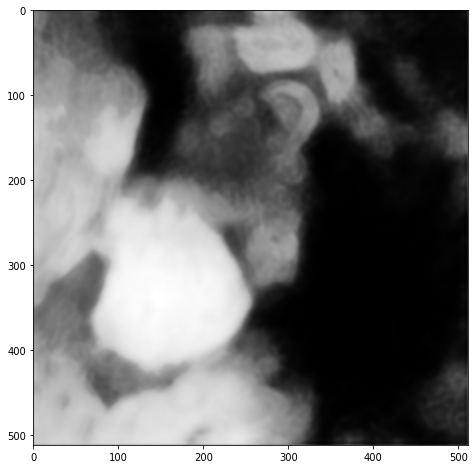

In [17]:
plt.imshow((pred_prob0 + pred_prob1 + pred_prob2 + pred_prob3 + pred_prob4) /5)

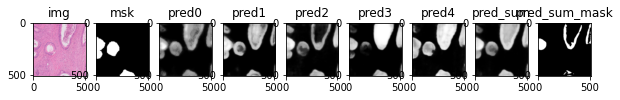

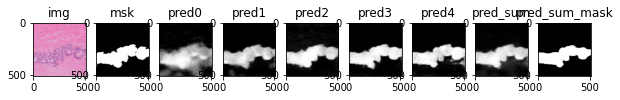

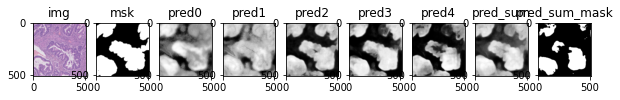

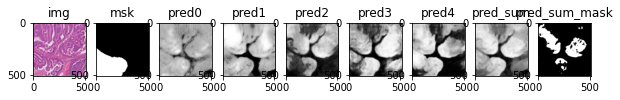

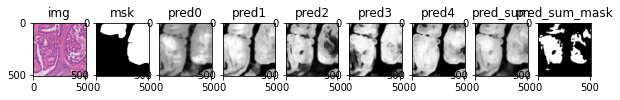

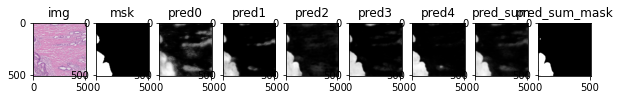

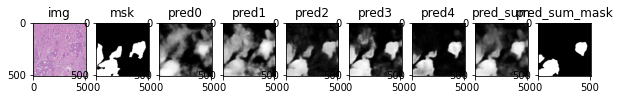

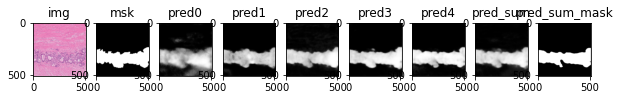

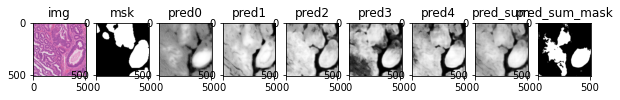

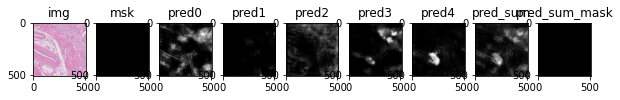

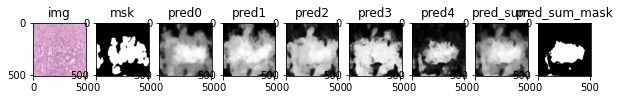

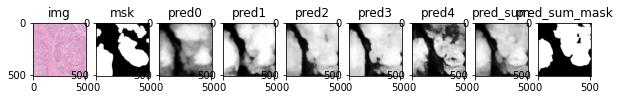

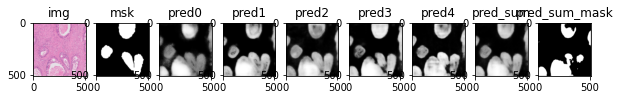

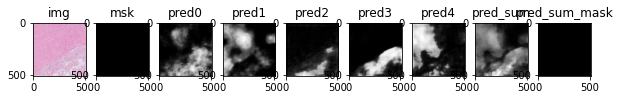

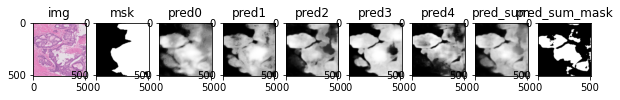

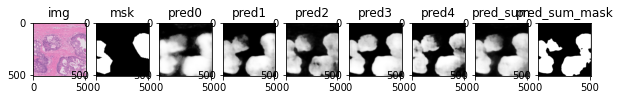

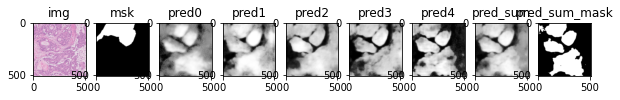

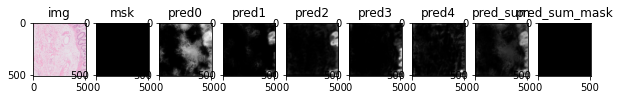

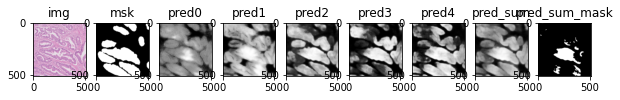

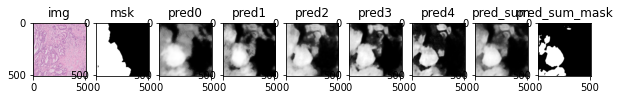

In [20]:
batch_set = test_set.take(1)
for img_batch,msk_batch in batch_set:
    for i in range(20):
        img_input = np.expand_dims(img_batch[i],axis =0)
        pred_prob0 = np.squeeze(model0.predict(img_input))
        #pred_mask0 = np.logical_and(pred_prob>0.5,1)
        
        pred_prob1 = np.squeeze(model1.predict(img_input))
        #pred_mask1 = np.logical_and(pred_prob>0.5,1)
        
        pred_prob2 = np.squeeze(model2.predict(img_input))
        #pred_mask2 = np.logical_and(pred_prob>0.5,1)
        
        pred_prob3 = np.squeeze(model3.predict(img_input))
        #pred_mask3 = np.logical_and(pred_prob>0.5,1)
        
        pred_prob4 = np.squeeze(model4.predict(img_input))
        #pred_mask4 = np.logical_and(pred_prob>0.5,1)
        
        pred_prob_sum = (pred_prob0 + pred_prob1 + pred_prob2 + pred_prob3 + pred_prob4) /5
        pred_prob_sum_mask = np.logical_and(pred_prob_sum>0.5,1)
        plt.figure()
        plt.subplot(1,9,1); plt.title('img') ; plt.imshow(img_batch[i])
        plt.subplot(1,9,2); plt.title('msk') ; plt.imshow(msk_batch[i])
        plt.subplot(1,9,3); plt.title('pred0') ; plt.imshow(pred_prob0)
        plt.subplot(1,9,4); plt.title('pred1') ; plt.imshow(pred_prob1)
        plt.subplot(1,9,5); plt.title('pred2') ; plt.imshow(pred_prob2)
        plt.subplot(1,9,6); plt.title('pred3') ; plt.imshow(pred_prob3)
        plt.subplot(1,9,7); plt.title('pred4') ; plt.imshow(pred_prob4)
        plt.subplot(1,9,8); plt.title('pred_sum') ; plt.imshow(pred_prob_sum)
        plt.subplot(1,9,9); plt.title('pred_sum_mask') ; plt.imshow(pred_prob_sum_mask)

### KERA_TUNER

from kerastuner import Hyperband, HyperParameter, HyperParameters, HyperModel

def build_model(hp):
    dice_loss = sm.losses.DiceLoss()
    focal_loss = sm.losses.BinaryFocalLoss(alpha=0.25, gamma=6.0)
    total_loss = dice_loss + focal_loss
    metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]
    
    BACKBONE = hp.Choice('backbone',['inceptionresnetv2','inceptionv3'])
    model = sm.Unet(BACKBONE,input_shape=(512,512,3),classes=1,activation='sigmoid',encoder_weights='imagenet')
    '''
    if hp.Choice('optimizer',['adam','sgd'])=='adam':
        model.compile(Adam(lr=hp.Choice('learning_rate',[1e-3,1e-4,1e-5])),total_loss,metrics)
    else:
        model.compile(SGD(lr=hp.Choice('learning_rate',[1e-3,1e-4,1e-5])),total_loss,metrics)
    '''
    model.compile(optimizer = Adam(hp.Float('learning_rate',1e-4,1e-2,sampling='log')),loss=total_loss,metrics=metrics)
    return model
    
## CALLBACK
model_path='./data/model/seg_tumor_0718.hdf5'
mc = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
es = EarlyStopping(monitor = 'val_loss',patience = 4)
lr = ReduceLROnPlateau(
    monitor='val_loss',  # 검증 손실을 기준으로 callback이 호출됩니다
    factor=0.5,          # callback 호출시 학습률을 1/2로 줄입니다
    patience=2,         # epoch 4 동안 개선되지 않으면 callback이 호출됩니다
)
class ClearTrainingOutput(tf.keras.callbacks.Callback):
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait = True)
callbacks_list = [mc,es,lr,ClearTrainingOutput()]

tuner = Hyperband(
    hypermodel=build_model,
    objective="val_loss",
    max_epochs=10,
    factor=3,
    hyperband_iterations=1,
    distribution_strategy=tf.distribute.MirroredStrategy(),
    directory='tumor_segmentation'
)

tuner.search(
    train_gen, 
    validation_data=valid_gen, 
    epochs=10,
    callbacks = callbacks_list
)

tuner.results_summary()

best_hp = tuner.get_best_hyperparameters()[0]

best_hp.values

best_model = tuner.hypermodel.build(best_hp)

model_path = './data/model/seg_tumor_tuner_inceptionv3.hdf5'
mc = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
es = EarlyStopping(monitor = 'val_loss',patience = 8)
lr = ReduceLROnPlateau(
    monitor='val_loss',  # 검증 손실을 기준으로 callback이 호출됩니다
    factor=0.5,          # callback 호출시 학습률을 1/2로 줄입니다
    patience=4,         # epoch 4 동안 개선되지 않으면 callback이 호출됩니다
)
callbacks_list = [mc,es,lr]

history = best_model.fit(
    train_gen,
    validation_data = valid_gen,
    callbacks = callbacks_list,
    epochs=EPOCHS,
    max_queue_size=15,
    use_multiprocessing=True,
    verbose=1
)
best_model.evaluate(test_gen)